<a href="https://colab.research.google.com/github/eflatlan/AliceO2/blob/Calib/Segmentation_HMPID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install h5py numpy

import os
import h5py
import numpy as np

from google.colab import drive
drive.mount('/content/drive')



In [ ]:
#!wget https://raw.githubusercontent.com/eflatlan/CNN_PID/dev_floatmap/helper_functions.py
#from helper_functions.py import print_points, plot_mapsm

In [ ]:





!wget -O ParticleDataUtilsCp.py https://raw.githubusercontent.com/eflatlan/CNN_PID/models_sacved/ParticleDataUtils15.py
from ParticleDataUtilsCp import ParticleDataUtils, classify_candidates_with_pad_sequences

!wget -O misc_helper_functions.py https://raw.githubusercontent.com/eflatlan/CNN_PID/models_sacved/misc_helper_functions2.py
from misc_helper_functions import build_species_layers, calculate_theta, filter_data, create_lr_scheduler,plot_lr, extract_neighborhood_map, create_cnn_model # plot_worst

!wget -O helper_functions.py https://raw.githubusercontent.com/eflatlan/CNN_PID/models_sacved/helper_functions.py
!wget -O plot_helper_functions.py https://raw.githubusercontent.com/eflatlan/CNN_PID/models_sacved/plot_helper_functions.py

import plot_helper_functions

from plot_helper_functions import plot_training_history
#from plot_helper_functions import plot_training_history#, plot_dist2mip_histograms, plot_maps


print(classify_candidates_with_pad_sequences)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

cmap = mcolors.LinearSegmentedColormap.from_list("", ["green", "red"])
import matplotlib.pyplot as plt
import numpy as np

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

def plot_individual_types(idx, x_pion, x_kaon,  x_proton, x_non, MIP_position, RAD_position, y_train, log_scale):
    datasets = [ x_pion, x_kaon, x_proton, x_non]
    titles = [ "Pion", "Kaon", "Proton", "Non"]

    # Find the global maximum charge for color scaling
    max_charge = 0
    for data in datasets:
        local_max = np.max(data[idx, :, 3])
        if local_max > max_charge:
            max_charge = local_max

    fig, ax = plt.subplots(2, 2, figsize=(14, 14))
    ax = ax.flatten()
    xm, ym = MIP_position[idx]
    xr, yr = RAD_position[idx]

    label_type = y_train[idx]
    fig.suptitle(f"Main Title: {label_type}", fontsize=16)  #

    cmap = plt.get_cmap('viridis')


    if log_scale:
      norm = LogNorm(vmin=1, vmax=max_charge)  # Assuming charge is positive and non-zero

    for i, (data, title) in enumerate(zip(datasets, titles)):
        x = data[idx, :, 0]
        y = data[idx, :, 1]
        charge = data[idx, :, 3]

        if log_scale:

          sc = ax[i].scatter(x, y, c=charge, cmap=cmap, norm=norm)  # Set norm

          plt.colorbar(sc, ax=ax[i], label='Charge (Log scale)', fraction=0.046, pad=0.04)
        else :
          sc = ax[i].scatter(x, y, c=charge, cmap=cmap, vmin=0, vmax=max_charge)  # Set vmin
          plt.colorbar(sc, ax=ax[i], label='Charge', fraction=0.046, pad=0.04)
        ax[i].scatter(xm, ym, color='green', marker='x', label='MIP_position')

        ax[i].set_title(title)
        ax[i].set_xlim([0, 130])
        ax[i].set_ylim([0, 130])
        ax[i].set_aspect('equal', adjustable='box')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def plot_combined_types(i, x_pion, x_kaon, x_proton, x_non, MIP_position, RAD_position, phiP, thetaP, y_train):
    label_type = y_train[i]

    phiP_val = phiP[i]
    thetaP_val = thetaP[i]
    fig, ax = plt.subplots(figsize=(7, 7))
    fig.suptitle(f"Main Title: {label_type}", fontsize=16)  # Added this line for main title

    xm, ym = MIP_position[i]
    xr, yr = RAD_position[i]
    for x, label, color in zip([x_proton, x_pion, x_kaon, x_non], ['Proton', 'Pion', 'Kaon', 'Non'], ['r', 'g', 'b', 'y']):
        x_val = x[i, :, 0]
        y_val = x[i, :, 1]

        ax.scatter(x_val, y_val, c=color, label=label, alpha=0.5)
    ax.scatter(xm, ym, color='green', marker='x', label='MIP_position')

    ax.legend()
    ax.set_title(f"Combined Types \nphiP: {float(phiP_val):.2f}, thetaP: {float(thetaP_val):.2f}")
    ax.set_xlim([0, 130])
    ax.set_ylim([0, 130])
    ax.set_aspect('equal', adjustable='box')

    plt.show() # base teh charge on  this : import matplotlib.pyplot as plt

def plot_combined_types3(i, x_pion, x_kaon, x_proton, x_non, MIP_position, RAD_position, phiP, thetaP, y_train, log_scale=True):
    label_type = y_train[i]
    phiP_val = phiP[i]
    thetaP_val = thetaP[i]

    fig, ax = plt.subplots(figsize=(7, 7))
    fig.suptitle(f"Main Title: {label_type}", fontsize=16)

    xm, ym = MIP_position[i]
    xr, yr = RAD_position[i]

    # Including all datasets and their corresponding properties
    datasets = [x_pion, x_kaon, x_proton, x_non]
    labels = ['Pion', 'Kaon', 'Proton', 'Non']
    colors = ['r', 'g', 'b', 'y']
    sizes = [60, 60, 60, 60] # All equal size

    # Keeping all markers as circles since that's the usual shape
    markers = ['o', 'o', 'o', 'o']

    max_charge = np.max([np.max(x[i, :, 3]) for x in datasets])
    cmap = plt.get_cmap('viridis')
    norm = LogNorm(vmin=1, vmax=max_charge) if log_scale else None
    for x, label, color, size, marker in zip(datasets, labels, colors, sizes, markers):
        x_val = x[i, :, 0]
        y_val = x[i, :, 1]
        charge = x[i, :, 3]

        sc = ax.scatter(x_val, y_val,  c=charge, cmap=cmap, norm=norm)  # Set norm

    plt.colorbar(sc, ax=ax, label='Charge (Log scale)' if log_scale else 'Charge', fraction=0.046, pad=0.04)
    ax.scatter(xm, ym, color='green', marker='x', label='MIP_position')

    ax.legend()
    ax.set_title(f"Combined Types \nphiP: {float(phiP_val):.2f}, thetaP: {float(thetaP_val):.2f}")
    ax.set_xlim([0, 130])
    ax.set_ylim([0, 130])
    ax.set_aspect('equal', adjustable='box')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()




In [ ]:
import matplotlib.pyplot as plt
import numpy as np  # Make sure to import numpy
import matplotlib.colors as mcolors

cmap = mcolors.LinearSegmentedColormap.from_list("", ["green", "red"])

def plot_first_instance(i, X_pion, X_kaon, X_proton, X_non, MIP_position, RAD_position, phiP, thetaP, y):
    # Extract values for the first instance

    Pions = X_pion[i] # these 4 in the 4x1 :)
    Kaons = X_kaon[i]
    X_proton = X_proton[i]
    Non = X_non[i]


    pdg = y[i] # one hot encoded -- 1 0
    if y[i,0] == 1:
      type = "pion"
      XYp = X_pion[i]

    elif y[i,1] == 1:
      type = "kaon"
      XYp = X_kaon[i]

    else :
      type = "proton"
      XYp = X_proton[i]

    # plot istedet hver type segmentert?

    phiP_val = phiP[i]
    thetaP_val = thetaP[i]



    #XYp = X_pion[i]
    Xp = XYp[:, 0]  # X-coordinate
    Yp = XYp[:, 1]  # Y-coordinate
    Charge = XYp[:, 3]  # Charge
    Size = XYp[:, 2]  # Size

    fig, ax = plt.subplots(1, 3, figsize=(21, 7))
    fig.suptitle(type, fontsize=16)
    plt.tight_layout()  # Automatic layout adjustment

    # Plot using charge without log scale
    sc0 = ax[0].scatter(Xp, Yp, c=Charge, cmap=cmap, label='X_pion')
    cbar0 = plt.colorbar(sc0, ax=ax[0], label='Charge', fraction=0.046, pad=0.04)
    ax[0].set_title(f"Charge as Color\nphiP: {float(phiP_val):.2f}, thetaP: {float(thetaP_val):.2f}")

    # Plot using charge on a log scale for color
    sc1 = ax[1].scatter(Xp, Yp, c=np.log1p(Charge), cmap=cmap, label='X_pion')
    cbar1 = plt.colorbar(sc1, ax=ax[1], label='Log(Charge)', fraction=0.046, pad=0.04)
    ax[1].set_title(f"Log-Scale Charge as Color\nphiP: {float(phiP_val):.2f}, thetaP: {float(thetaP_val):.2f}")

    # Plot using Size for color with a linear color map
    sc2 = ax[2].scatter(Xp, Yp, c=Size, cmap=cmap, label='X_pion')
    cbar2 = plt.colorbar(sc2, ax=ax[2], label='Size', fraction=0.046, pad=0.04)
    ax[2].set_title(f"Size as Color\nphiP: {float(phiP_val):.2f}, thetaP: {float(thetaP_val):.2f}")

    xm, ym = MIP_position[i]
    xr, yr = RAD_position[i]

    # Plot MIP_position and RAD_position on all plots
    i = 1
    for a in ax:
        if i == 2:
          a.scatter(xm, ym, color='green', marker='x', label='MIP_position')
          a.scatter(xr, yr, color='orange', marker='x', label='RAD_position')
          a.legend()
        i += 1
        # Set x and y limits for the plot
        a.set_xlim([0, 130])
        a.set_ylim([0, 130])

        # Set aspect ratio to be equal
        a.set_aspect('equal', adjustable='box')

    plt.show()


# Helping class and imports


In [ ]:
#resolution = 4

from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle

import sys

print(sys.getrecursionlimit()) # Prints 1000

print_vals = False
from numpy.linalg import norm
from tensorflow.keras.backend import expand_dims
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import precision_recall_curve, confusion_matrix

from scipy.signal import find_peaks

from __future__ import print_function
import os
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Input, Conv2D, Lambda, Flatten, Dense, concatenate, BatchNormalization, MaxPooling2D, Dropout, LeakyReLU, Masking, Embedding

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt


from tensorflow.keras.callbacks import EarlyStopping

# Model

In [ ]:

class MassClassifier:
  def __init__(self, percentage_to_read = 10, resolution = 4):
      self.model = None
      self.utils = None
      self.percentage_to_read = percentage_to_read
      self.resolution = resolution
      self.particle_vector = None


  def load_data(self, filenames):

      print(f"MassClassifier __ load_data")

      self.utils = ParticleDataUtils(filenames, percentage_to_read = self.percentage_to_read) # specify percentage of particles to read..
      # when init on ParticleDataUtils is called, it calls its member function function         self.particle_vector = self.load_data(filename)
      if  self.particle_vector is None :
        print(f"self.particle_vector is None")

        self.particle_vector = self.utils.particle_vector
      else :
        print(f"self.particle_vector is not None")
        self.particle_vector.extend(self.utils.particle_vector)

      print(f"Number of particles: {len(self.particle_vector)}")

  def preprocess_data(self):
      particle_info = self.utils.particle_info
      particle_info = self.particle_vector


      from tensorflow.keras.preprocessing.sequence import pad_sequences

      # Convert pion_candidates, kaon_candidates, proton_candidates to lists
      pion_candidates_list =[info.pion_candidates for info in particle_info]
      kaon_candidates_list = ([info.kaon_candidates for info in particle_info])
      proton_candidates_list = ([info.proton_candidates for info in particle_info])
      non_candidates_list = ([info.non_candidates for info in particle_info])



      #plot_function(X_train_pion_candidates, X_train_kaon_candidates, X_train_proton_candidates, X_train_mip_position, X_train_rad_position, X_train_phi, X_train_theta)
      print("Fields in the first vector of X_train:")
      print("pion_candidates_list shape:",  np.array(pion_candidates_list).shape)
      print("kaon_candidates_list shape:",  np.array(kaon_candidates_list).shape)
      print("proton_candidates_list shape:",  np.array(proton_candidates_list).shape)


      # Pad the lists to the longest vector per dimension
      X_pion_candidates =  np.array(pion_candidates_list).astype(np.float32)#pad_sequences(pion_candidates_list, padding='post')
      X_kaon_candidates =  np.array(kaon_candidates_list).astype(np.float32)#pad_sequences(kaon_candidates_list, padding='post')
      X_proton_candidates = np.array(proton_candidates_list).astype(np.float32)# pad_sequences(proton_candidates_list, padding='post')
      X_non_candidates = np.array(non_candidates_list).astype(np.float32)# pad_sequences(proton_candidates_list, padding='post')



      print(f"PADDED \n:")
      print("X_pion_candidates shape:", X_pion_candidates.shape)
      print("X_kaon_candidates shape:", X_kaon_candidates.shape)
      print("X_proton_candidates shape:", X_proton_candidates.shape)


      # scalars
      X_momentum = np.array([info.momentum for info in particle_info])#.reshape(-1, 32, 32, 1)
      X_refractive_index = np.array([info.refractiveIndex for info in particle_info])#.reshape(-1, 32, 32, 1)

      # this should not be included? :
      print(f"PADDED \n:")

      X_phi = np.array([particle.phiP for particle in particle_info])      # new
      X_theta = np.array([particle.thetaP for particle in particle_info])  # new

      X_phi = np.array([particle.phiP for particle in particle_info])      # new
      X_theta = np.array([particle.thetaP for particle in particle_info])  # new



      # x,y pairs (2,1) :
      X_mip_position = np.array([info.mip_position for info in particle_info]) # was already
      X_rad_position = np.array([info.rad_position for info in particle_info]) # new

      X_mCluCharge = np.array([info.mCluCharge for info in particle_info]) # was already
      X_mCluSize = np.array([info.mCluSize for info in particle_info]) # new


      print(np.asarray(X_proton_candidates, dtype=object).shape)

      len_proton = np.asarray(X_proton_candidates, dtype = object).shape[1]


      # Prepare the outputs
      y = np.array([info.particleType  for info in particle_info])
      # if pdg == 211 -- pion 321 kaon 2212 proton else "other"


      # Convert the outputs to one-hot encoded vectors
      lb = LabelBinarizer()
      y = lb.fit_transform(y)

      # Split the data into train and test sets
      map_size = nb_size = 50

      # ef :TODO fix this back again
      X_map_pion = extract_neighborhood_map(candidate_positions = X_pion_candidates, mip_positions = X_mip_position, neighborhood_size = nb_size, map_size = map_size)
      X_map_kaon =extract_neighborhood_map(candidate_positions = X_kaon_candidates, mip_positions = X_mip_position, neighborhood_size = nb_size, map_size = map_size)
      X_map_proton =extract_neighborhood_map(candidate_positions = X_proton_candidates, mip_positions = X_mip_position, neighborhood_size = nb_size, map_size = map_size)


      print("X_map_pion shape:", X_map_pion.shape)
      print("X_map_kaon shape:", X_map_kaon.shape)
      print("X_map_proton shape:", X_map_proton.shape)


      X_train_mCluCharge, X_test_mCluCharge, \
      X_train_mCluSize, X_test_mCluSize, \
      X_train_pion_candidates, X_test_pion_candidates, \
      X_train_kaon_candidates, X_test_kaon_candidates, \
      X_train_proton_candidates, X_test_proton_candidates, \
      X_train_non_candidates, X_test_non_candidates, \
      X_train_momentum, X_test_momentum, \
      X_train_refractive_index, X_test_refractive_index, \
      X_train_phi, X_test_phi, \
      X_train_theta, X_test_theta, \
      X_train_mip_position, X_test_mip_position, \
      X_train_rad_position, X_test_rad_position, \
      X_train_map_pion, X_test_map_pion, \
      X_train_map_kaon, X_test_map_kaon, \
      X_train_map_proton, X_test_map_proton, \
      y_train, y_test = \
      train_test_split(
          X_mCluCharge, X_mCluSize,
          X_pion_candidates, X_kaon_candidates,
          X_proton_candidates, X_non_candidates,
          X_momentum,
          X_refractive_index, X_phi,
          X_theta, X_mip_position,
          X_rad_position, X_map_pion,
          X_map_kaon, X_map_proton,
          y,
          test_size=0.2,
          #random_state=42#,shuffle=True
      )


      import copy

      X_train = {
          "X_train_momentum": X_train_momentum,
          "X_train_refractive_index": X_train_refractive_index,
          "X_train_phi": X_train_phi,
          "X_train_theta": X_train_theta,
          "X_train_mip_position": X_train_mip_position,
          "X_train_rad_position": X_train_rad_position,
          "X_train_pion_candidates": X_train_pion_candidates,
          "X_train_kaon_candidates": X_train_kaon_candidates,
          "X_train_proton_candidates": X_train_proton_candidates,
          "X_train_non_candidates": X_train_non_candidates,
          "X_train_map_pion": X_train_map_pion,
          "X_train_map_kaon": X_train_map_kaon,
          "X_train_map_proton": X_train_map_proton,
          "X_train_mCluCharge": X_train_mCluCharge,  # New addition
          "X_train_mCluSize": X_train_mCluSize       # New addition
      }

      X_test = {
          "X_test_momentum": X_test_momentum,
          "X_test_refractive_index": X_test_refractive_index,
          "X_test_phi": X_test_phi,
          "X_test_theta": X_test_theta,
          "X_test_mip_position": X_test_mip_position,
          "X_test_rad_position": X_test_rad_position,
          "X_test_pion_candidates": X_test_pion_candidates,
          "X_test_kaon_candidates": X_test_kaon_candidates,
          "X_test_proton_candidates": X_test_proton_candidates,
          "X_test_non_candidates" : X_test_non_candidates,
          "X_test_map_pion": X_test_map_pion,
          "X_test_map_kaon": X_test_map_kaon,
          "X_test_map_proton": X_test_map_proton,
          "X_test_mCluCharge": X_test_mCluCharge,  # New addition
          "X_test_mCluSize": X_test_mCluSize        # New addition
      }


      X_train_unscaled = copy.deepcopy(X_train)
      X_test_unscaled = copy.deepcopy(X_test)

      def log_scaler_pion_size(X):
          return np.log1p(X)  # log(x + 1)

      def log_scaler_pion_charge(X):
          return np.log(X + 1e-5)  # log(x + small constant)
      from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, StandardScaler, RobustScaler

      log_transformer_pion_size = FunctionTransformer(func=np.vectorize(log_scaler_pion_size), validate=True)
      log_transformer_pion_charge = FunctionTransformer(func=np.vectorize(log_scaler_pion_charge), validate=True)

      min_scaler = MinMaxScaler()
      std_scaler = StandardScaler()
      robust_scaler = RobustScaler()

      n_features = 4

      for i in range(n_features):
          if i < 2:
              scaler = min_scaler
          elif i == 2:  # size: peak around 2-- exp decr
              scaler = log_transformer_pion_size
          else:  # charge ; peak at 0 decr exp
              scaler = log_transformer_pion_charge

          X_train_pion_candidates[:, :, i] = scaler.fit_transform(X_train_pion_candidates[:, :, i])
          X_test_pion_candidates[:, :, i] =scaler.transform(X_test_pion_candidates[:, :, i])
          X_train_kaon_candidates[:, :, i] = scaler.fit_transform(X_train_kaon_candidates[:, :, i])
          X_test_kaon_candidates[:, :, i] = scaler.transform(X_test_kaon_candidates[:, :, i])
          X_train_proton_candidates[:, :, i] = scaler.fit_transform(X_train_proton_candidates[:, :, i])
          X_test_proton_candidates[:, :, i] =scaler.transform(X_test_proton_candidates[:, :, i])


          X_train_non_candidates[:, :, i] = scaler.fit_transform(X_train_non_candidates[:, :, i])
          X_test_non_candidates[:, :, i] =scaler.transform(X_test_non_candidates[:, :, i])

      # print(X_train_rad_position.shape)




      X_train_rad_position[:, 0] = min_scaler.fit_transform(X_train_rad_position[:, 0])
      X_train_rad_position[:, 1] = min_scaler.fit_transform(X_train_rad_position[:, 1])

      X_test_rad_position[:, 0] = min_scaler.transform(X_test_rad_position[:, 0])
      X_test_rad_position[:, 1] = min_scaler.transform(X_test_rad_position[:, 1])

      X_train_mip_position[:, 0] = min_scaler.fit_transform(X_train_mip_position[:, 0])
      X_train_mip_position[:, 1] = min_scaler.fit_transform(X_train_mip_position[:, 1])

      X_test_mip_position[:, 0] = min_scaler.transform(X_test_mip_position[:, 0])
      X_test_mip_position[:, 1] = min_scaler.transform(X_test_mip_position[:, 1])

      X_train_momentum = robust_scaler.fit_transform(X_train_momentum.reshape(-1, 1)).flatten()
      X_test_momentum = robust_scaler.transform(X_test_momentum.reshape(-1, 1)).flatten()

      # For phi
      X_train_phi = robust_scaler.fit_transform(X_train_phi.reshape(-1, 1)).flatten()
      X_test_phi = robust_scaler.transform(X_test_phi.reshape(-1, 1)).flatten()

      # For theta
      X_train_theta = robust_scaler.fit_transform(X_train_theta.reshape(-1, 1)).flatten()
      X_test_theta = robust_scaler.transform(X_test_theta.reshape(-1, 1)).flatten()

      # For refractive index
      X_train_refractive_index = self.utils.refractive_index_scaler.fit_transform(X_train_refractive_index.reshape(-1, 1)).flatten()
      X_test_refractive_index = self.utils.refractive_index_scaler.transform(X_test_refractive_index.reshape(-1, 1)).flatten()

      # For mCluCharge
      X_train_mCluCharge =robust_scaler.fit_transform(X_train_mCluCharge.reshape(-1, 1)).flatten()  # Assumes you've created mCluCharge_scaler
      X_test_mCluCharge = robust_scaler.transform(X_test_mCluCharge.reshape(-1, 1)).flatten()

      # For mCluSize
      X_train_mCluSize = robust_scaler.fit_transform(X_train_mCluSize.reshape(-1, 1)).flatten()  # Assumes you've created mCluSize_scaler
      X_test_mCluSize = robust_scaler.transform(X_test_mCluSize.reshape(-1, 1)).flatten()

      X_train = {
          "X_train_momentum": X_train_momentum,
          "X_train_refractive_index": X_train_refractive_index,
          "X_train_phi": X_train_phi,
          "X_train_theta": X_train_theta,
          "X_train_mip_position": X_train_mip_position,
          "X_train_rad_position": X_train_rad_position,
          "X_train_pion_candidates": X_train_pion_candidates,
          "X_train_kaon_candidates": X_train_kaon_candidates,
          "X_train_proton_candidates": X_train_proton_candidates,
          "X_train_non_candidates" : X_train_non_candidates,
          "X_train_map_pion": X_train_map_pion,
          "X_train_map_kaon": X_train_map_kaon,
          "X_train_map_proton": X_train_map_proton,
          "X_train_mCluCharge": X_train_mCluCharge,  # New addition
          "X_train_mCluSize": X_train_mCluSize       # New addition
      }

      X_test = {
          "X_test_momentum": X_test_momentum,
          "X_test_refractive_index": X_test_refractive_index,
          "X_test_phi": X_test_phi,
          "X_test_theta": X_test_theta,
          "X_test_mip_position": X_test_mip_position,
          "X_test_rad_position": X_test_rad_position,
          "X_test_pion_candidates": X_test_pion_candidates,
          "X_test_kaon_candidates": X_test_kaon_candidates,
          "X_test_proton_candidates": X_test_proton_candidates,
          "X_test_non_candidates" : X_test_non_candidates,
          "X_test_map_pion": X_test_map_pion,
          "X_test_map_kaon": X_test_map_kaon,
          "X_test_map_proton": X_test_map_proton,
          "X_test_mCluCharge": X_test_mCluCharge,  # New addition
          "X_test_mCluSize": X_test_mCluSize        # New addition
      }
      print(f"  return (X_train, X_test, y_train, y_test) \n:")

      return (X_train, X_test, X_train_unscaled, X_test_unscaled, y_train, y_test)


  def plot_hist(self, X_train=None, X_test=None, description = None):
    import warnings
    try:
      def check_nan_inf(arr):
          return np.isnan(arr).any(), np.isinf(arr).any()

      for label, variable in {**X_train, **X_test}.items():
          has_nan, has_inf = check_nan_inf(variable)
          if has_nan or has_inf:
              warnings.warn(f"{label} contains NaN or Inf values. This may lead to issues.")

      fig, axs = plt.subplots(2, 5, figsize=(25, 10))
      fig.suptitle(f"Training and Testing Data: {description}", fontsize=20)
      fig1, axs1 = plt.subplots(2, 3, figsize=(18, 10))
      fig1.suptitle(f"2D Maps and Projections: {description}", fontsize=20)
      fig2, axs2 = plt.subplots(2, 4, figsize=(16, 10))
      fig2.suptitle(f"Pion Candidate Distributions: {description}", fontsize=20)


      def plot_routine(variables, row_idx):
          axs_idx = 0
          for label, variable in variables.items():
              if label == 'MIP Position' or label == 'Rad Position':
                  variable = np.asarray(variable).reshape(-1, 2)
                  mask = (variable[:, 0] != 0) & (variable[:, 1] != 0)
                  variable = variable[mask]
                  axs1[row_idx, 0].scatter(variable[:, 0], variable[:, 1], marker='o', s=10)
                  axs1[row_idx, 0].set_title(f"{'Train' if row_idx == 0 else 'Test'} 2D Map: {label}")
                  axs1[row_idx, 1].hist(variable[:, 0], edgecolor='black')
                  axs1[row_idx, 1].set_title(f"{label} X")
                  axs1[row_idx, 2].hist(variable[:, 1], edgecolor='black')
                  axs1[row_idx, 2].set_title(f"{label} Y")

              elif label == 'Pion Candidates':
                  variable = np.asarray(variable)
                  print(f"variable shape {variable.shape}")
                  mask = np.any(variable != 0, axis=-1)
                  filtered_variable = variable[mask]
                  variable = np.asarray(variable)

                  if row_idx == 0 : range = (0, 125)
                  else :  range = (0, 1)
                  axs2[row_idx, 0].hist(variable[:, :, 0][variable[:, :, 0] > 0], bins=25, range = range, edgecolor='black')
                  axs2[row_idx, 0].set_title(f"{'Train' if row_idx == 0 else 'Test'} Pion X")
                  axs2[row_idx, 1].hist(variable[:, :, 1][variable[:, :, 1] > 0], bins=25, range = range, edgecolor='black')
                  axs2[row_idx, 1].set_title(f"{'Train' if row_idx == 0 else 'Test'} Pion Y")

                  if row_idx == 0  : range =(0, 11)
                  else : range = (0, 1)
                  axs2[row_idx, 2].hist(variable[:, :, 2][variable[:, :, 2] > 0], bins=12, range = range, edgecolor='black')
                  axs2[row_idx, 2].set_title(f"{'Train' if row_idx == 0 else 'Test'} Pion Size")

                  if row_idx == 0 :  range =(0, 350)
                  else : range  = (0, 1)
                  axs2[row_idx, 3].hist(variable[:, :, 3][variable[:, :, 3] > 0], bins=100, range = range, edgecolor='black') # logaritmisk her ?
                  axs2[row_idx, 3].set_title(f"{'Train' if row_idx == 0 else 'Test'} Pion Charge")
              else:
                  #variable = np.clip(variable, a_min=-500, a_max=10000)

                  if label == "mCluSize":
                    bins = 12
                    axs[row_idx, axs_idx].hist(variable, bins = bins, range=(0, 11), edgecolor='black')
                    axs[row_idx, axs_idx].set_title(f"{'Train' if row_idx == 0 else 'Test'} MIP Size")
                    axs_idx += 1
                  else:
                    if label == "Phi":
                      bins = 64
                    elif label == "Theta":
                      bins =50
                    elif label == "Momentum":
                      bins = 50
                    else :
                      bins = "auto"

                    axs[row_idx, axs_idx].hist(variable, bins = bins, edgecolor='black')
                    axs[row_idx, axs_idx].set_title(f"{'Train' if row_idx == 0 else 'Test'} {label}")
                    axs_idx += 1



      X_train_variables = {
          'Refractive Index': X_train["X_train_refractive_index"],
          'Momentum': X_train["X_train_momentum"],
          'Phi': X_train["X_train_phi"],
          'Theta': X_train["X_train_theta"],
          'mCluSize': X_train["X_train_mCluSize"],
          'MIP Position': X_train["X_train_mip_position"],
          'Rad Position': X_train["X_train_rad_position"],
          'Pion Candidates': X_train["X_train_pion_candidates"],
      }

      X_test_variables = {
          'Refractive Index': X_test["X_test_refractive_index"],
          'Momentum': X_test["X_test_momentum"],
          'Phi': X_test["X_test_phi"],
          'Theta': X_test["X_test_theta"],
          'mCluSize': X_test["X_test_mCluSize"],
          'MIP Position': X_test["X_test_mip_position"],
          'Rad Position': X_test["X_test_rad_position"],
          'Pion Candidates': X_test["X_test_pion_candidates"],
      }

      plot_routine(X_train_variables, 0)
      plot_routine(X_test_variables, 1)

      plt.show()

    except Exception as e:
        warnings.warn(f"An exception occurred: {e}")

  # TODO: to this to the new data-fields :
  def plot_hist2(self, input_sequence_length = None, X_train = None, X_test = None, y_train = None, y_test = None, description=None):
      #map_shape = (None, None, 1)  # Variable shape for the map input
      #X_train_photon_ckov_segmented shape : (1955, 3, 74)

      # create a map with resolution to be chosen, iterate over teh filledBins vector
      #X_map = np.array([create_map(filledBins = info.filledBins, resolution = self.resolution) for info in particle_info])
      #filled_bins_array = np.array([info.filledBins for info in particle_info], dtype=object)

      X_train_pion_candidates = X_train["X_train_pion_candidates"]
      X_train_kaon_candidates = X_train["X_train_kaon_candidates"]
      X_train_proton_candidates = X_train["X_train_proton_candidates"]
      X_train_momentum = X_train["X_train_momentum"]
      X_train_refractive_index = X_train["X_train_refractive_index"]
      X_train_phi = X_train["X_train_phi"]
      X_train_theta = X_train["X_train_theta"]
      X_train_mip_position = X_train["X_train_mip_position"]
      X_train_rad_position = X_train["X_train_rad_position"]

      X_test_pion_candidates = X_test["X_test_pion_candidates"]
      X_test_kaon_candidates = X_test["X_test_kaon_candidates"]
      X_test_proton_candidates = X_test["X_test_proton_candidates"]
      X_test_momentum = X_test["X_test_momentum"]
      X_test_refractive_index = X_test["X_test_refractive_index"]
      X_test_phi = X_test["X_test_phi"]
      X_test_theta = X_test["X_test_theta"]
      X_test_mip_position = X_test["X_test_mip_position"]
      X_test_rad_position = X_test["X_test_rad_position"]

      # Plot 2D map for one instance of pion, kaon, and proton
      pion_candidates_train = np.array(X_train_pion_candidates).astype(np.float32)
      kaon_candidates_train = np.array(X_train_kaon_candidates).astype(np.float32)
      proton_candidates_train = np.array(X_train_proton_candidates).astype(np.float32)


      # Plot 2D map for one instance of pion, kaon, and proton
      pion_candidates_test = np.array(X_test_pion_candidates).astype(np.float32)
      kaon_candidates_test = np.array(X_test_kaon_candidates).astype(np.float32)
      proton_candidates_test = np.array(X_test_proton_candidates).astype(np.float32)


      fig, axs = plt.subplots(2, 4, figsize=(20, 10))

      train_variables = [X_train_refractive_index, X_train_momentum, X_train_mip_position, X_train_phi, X_train_theta]
      train_labels = ['Train Refractive Index', 'Train Momentum', 'Train MIP Position', 'Train phi', 'Train theta']

      X_train_mip_position = (np.asarray(X_train_mip_position)).reshape(len(X_train_mip_position), 2)
      print(f"X_train_mip_position shape = {X_train_mip_position.shape}")
      for i, variable in enumerate(train_variables):
          if i < 3:  # variable.ndim == 1: # For 1D data
              axs[0, i].hist(variable, edgecolor='black')
              axs[0, i].set_title(train_labels[i])
          elif i == 3:  # For 2D data
              axs2[0].scatter(X_train_mip_position[:, 0], X_train_mip_position[:, 1], marker='o', s=10)
              axs2[0].set_title('2D Map: MIP Position')
              axs2[0].set_xlabel('X position')
              axs2[0].set_ylabel('Y position')
          else:  # For 1D data
              axs[0, i].hist(variable, edgecolor='black')
              axs[0, i].set_title(train_labels[i])

      # For test data
      test_variables = [X_test_refractive_index, X_test_momentum, X_test_mip_position, X_test_phi, X_test_theta]
      test_labels = ['Test Refractive Index', 'Test Momentum','Test MIP Position', 'Test phiP', 'Test thetaP']


      X_test_mip_position = (np.asarray(X_test_mip_position)).reshape(len(X_test_mip_position), 2)
      print(f"X_test_mip_position shape = {X_test_mip_position.shape}")

      for i, variable in enumerate(test_variables):
          if i < 3:  # variable.ndim == 1: # For 1D data
              axs[1, i].hist(variable, edgecolor='black')
              axs[1, i].set_title(test_labels[i])
          elif i == 3:  # For 2D data
              axs2[1].scatter(X_test_mip_position[:, 0], X_test_mip_position[:, 1], marker='o', s=10)
              axs2[1].set_title('2D Map: MIP Position')
              axs2[1].set_xlabel('X position')
              axs2[1].set_ylabel('Y position')
          else:  # For 1D data
              axs[1, i].hist(variable, edgecolor='black')
              axs[1, i].set_title(test_labels[i])

      plt.show()

      len_pion = np.asarray(pion_candidates_test, dtype = object).shape[1]
      len_kaon = np.asarray(kaon_candidates_test, dtype = object).shape[1]
      len_proton = np.asarray(proton_candidates_train, dtype = object).shape[1]

      # print(f" pion_candidates_test lastdim = {len_pion}")
      # print(f" kaon_candidates_train lastdim = {len_kaon}")
      # print(f" proton_candidates_train lastdim = {len_proton}")

      max_value = np.max(pion_candidates_test)

      # Find the minimum value across all dimensions
      min_value = np.min(pion_candidates_test)

      # print("pion_candidates_test Maximum value:", max_value)
      # print("pion_candidates_test Minimum value:", min_value)

      # print(f" pion_candidates_test lastdim = {np.asarray(pion_candidates_test, dtype = object).shape[1]}")
      # print(f" kaon_candidates_test lastdim = {np.asarray(kaon_candidates_test, dtype = object).shape[1]}")
      # print(f" proton_candidates_test lastdim = {np.asarray(proton_candidates_test, dtype = object).shape[1]}")




      pion_candidates_train = np.array(pion_candidates_train).astype(np.float32)
      kaon_candidates_train = np.array(kaon_candidates_train).astype(np.float32)
      proton_candidates_train = np.array(proton_candidates_train).astype(np.float32)


      x_train = np.asarray([pion_candidates_train, kaon_candidates_train, proton_candidates_train], dtype = "object")
      x_test = np.asarray([pion_candidates_test, kaon_candidates_test, proton_candidates_test], dtype = "object")


      #x_train shape = (3, 1955, 74) pion_candidates_test shape = (489, 74) proton_candidates_train_tf shape = (1955, 74)
      print(f"x_train shape = {np.asarray(x_train, dtype = object).shape}")
      print(f"pion_candidates_test shape = {np.asarray(pion_candidates_test, dtype = object).shape}")



      fig2, axs2 = plt.subplots(2, 3, figsize=(18, 12))
      strings_desc = ["pion", "kaon", "proton"]
      for i in range(3):
          axs2[0, i].hist(x_train[i, :, :],  bins=np.arange(0.05, 0.8, 0.01), edgecolor='black')
          axs2[0, i].set_title(f'Histogram for Ckov Train data: {strings_desc[i]}')
          axs2[0, i].set_xlabel('Value')
          axs2[0, i].set_ylabel('Frequency')

          axs2[1, i].hist(x_test[i, :, :],  bins=np.arange(0.05, 0.8, 0.01), edgecolor='black')
          axs2[1, i].set_title(f'Histogram for Ckov Test data: {strings_desc[i]}')
          axs2[1, i].set_xlabel('Value')
          axs2[1, i].set_ylabel('Frequency')

      plt.show()

      x_train_tf = np.asarray([pion_candidates_train, kaon_candidates_train, proton_candidates_train], dtype = object)
      x_test_tf = np.asarray([pion_candidates_test, kaon_candidates_test, proton_candidates_test], dtype = object)

      print(f"x_train_tf shape = {x_train_tf.shape}")

      fig3, axs3 = plt.subplots(2, 3, figsize=(18, 12))
      for i in range(3):
          axs3[0, i].hist(x_train_tf[i, :, :],  bins=np.arange(0.1, 0.8, 0.01), edgecolor='black')
          axs3[0, i].set_title(f'Histogram for TF : Ckov Train data: {strings_desc[i]}')
          axs3[0, i].set_xlabel('Value')
          axs3[0, i].set_ylabel('Frequency')

          axs3[1, i].hist(x_test_tf[i, :, :],  bins=np.arange(0.1, 0.8, 0.01), edgecolor='black')
          axs3[1, i].set_title(f'Histogram for TF :Ckov Test data: {strings_desc[i]}')
          axs3[1, i].set_xlabel('Value')
          axs3[1, i].set_ylabel('Frequency')

      plt.show()

      # Plot 2D map for one instance of pion, kaon, and proton
      pion_candidates_train = np.array(pion_candidates_train).astype(np.float32)
      kaon_candidates_train = np.array(kaon_candidates_train).astype(np.float32)
      proton_candidates_train = np.array(proton_candidates_train).astype(np.float32)

      pion_instance = pion_candidates_train[0]
      kaon_instance = kaon_candidates_train[0]
      proton_instance = proton_candidates_train[0]

      axs2[2].scatter(pion_instance[:, 0], pion_instance[:, 1], c='r', marker='o', label='Pion', s=20)
      axs2[2].scatter(kaon_instance[:, 0], kaon_instance[:, 1], c='g', marker='s', label='Kaon', s=20)
      axs2[2].scatter(proton_instance[:, 0], proton_instance[:, 1], c='b', marker='^', label='Proton', s=20)
      axs2[2].set_title('2D Map: Particle Instances')
      axs2[2].set_xlabel('X position')
      axs2[2].set_ylabel('Y position')
      axs2[2].legend()



  def build_model(self, input_sequence_length = None, X_train = None, X_test = None, y_train = None, y_test = None, mask = None, epochs = None, include_cnn = False, units = None, units2 = None, final_concat_units = None, CNN_units = None):

      dropout = 0.2
      alpha = 0.05

      #map_shape = (None, None, 1)  # Variable shape for the map input
      #X_train_photon_ckov_segmented shape : (1955, 3, 74)

      X_train_pion_candidates = X_train["X_train_pion_candidates"]
      X_train_kaon_candidates = X_train["X_train_kaon_candidates"]
      X_train_proton_candidates = X_train["X_train_proton_candidates"]

      X_train_non_candidates = X_train["X_train_non_candidates"]
      X_train_momentum = X_train["X_train_momentum"]
      X_train_refractive_index = X_train["X_train_refractive_index"]
      X_train_phi = X_train["X_train_phi"]
      X_train_theta = X_train["X_train_theta"]
      X_train_mip_position = X_train["X_train_mip_position"]
      X_train_rad_position = X_train["X_train_rad_position"]
      X_train_map_pion = X_train["X_train_map_pion"]
      X_train_map_kaon = X_train["X_train_map_kaon"]
      X_train_map_proton = X_train["X_train_map_proton"]

      X_test_pion_candidates = X_test["X_test_pion_candidates"]
      X_test_kaon_candidates = X_test["X_test_kaon_candidates"]
      X_test_proton_candidates = X_test["X_test_proton_candidates"]
      X_test_non_candidates = X_test["X_test_non_candidates"]
      X_test_momentum = X_test["X_test_momentum"]
      X_test_refractive_index = X_test["X_test_refractive_index"]
      X_test_phi = X_test["X_test_phi"]
      X_test_theta = X_test["X_test_theta"]
      X_test_mip_position = X_test["X_test_mip_position"]
      X_test_rad_position = X_test["X_test_rad_position"]
      X_test_map_pion = X_test["X_test_map_pion"]
      X_test_map_kaon = X_test["X_test_map_kaon"]
      X_test_map_proton = X_test["X_test_map_proton"]

      X_train_mCluCharge = X_train["X_train_mCluCharge"]
      X_train_mCluSize = X_train["X_train_mCluSize"]
      X_test_mCluCharge = X_test["X_test_mCluCharge"]
      X_test_mCluSize = X_test["X_test_mCluSize"]


      X_test_map_pion = tf.expand_dims(X_test_map_pion, axis=-1)
      X_test_map_kaon = tf.expand_dims(X_test_map_kaon, axis=-1)
      X_test_map_proton = tf.expand_dims(X_test_map_proton, axis=-1)


      X_train_map_pion = tf.expand_dims(X_train_map_pion, axis=-1)
      X_train_map_kaon = tf.expand_dims(X_train_map_kaon, axis=-1)
      X_train_map_proton = tf.expand_dims(X_train_map_proton, axis=-1)

      #plot_function(X_train_pion_candidates, X_train_kaon_candidates, X_train_proton_candidates, X_train_mip_position, X_train_rad_position, X_train_phi, X_train_theta)
      print("Fields in the first vector of X_train:")
      print("X_train_pion_candidates shape:", X_train_pion_candidates.shape)
      print("X_train_kaon_candidates shape:", X_train_kaon_candidates.shape)
      print("X_train_proton_candidates shape:", X_train_proton_candidates.shape)
      print("X_train_momentum shape:", X_train_momentum.shape)
      print("X_train_refractive_index shape:", X_train_refractive_index.shape)
      print("X_train_phi shape:", X_train_phi.shape)
      print("X_train_theta shape:", X_train_theta.shape)
      print("X_train_mip_position shape:", X_train_mip_position.shape)
      print("X_train_rad_position shape:", X_train_rad_position.shape)
      print("X_train_map_pion shape:", X_train_map_pion.shape)
      print("X_train_map_kaon shape:", X_train_map_kaon.shape)
      print("X_train_map_proton shape:", X_train_map_proton.shape)

      print("\nFields in the first vector of X_test:")
      print("X_test_pion_candidates shape:", X_test_pion_candidates.shape)
      print("X_test_kaon_candidates shape:", X_test_kaon_candidates.shape)
      print("X_test_proton_candidates shape:", X_test_proton_candidates.shape)
      print("X_test_momentum shape:", X_test_momentum.shape)
      print("X_test_refractive_index shape:", X_test_refractive_index.shape)
      print("X_test_phi shape:", X_test_phi.shape)
      print("X_test_theta shape:", X_test_theta.shape)
      print("X_test_mip_position shape:", X_test_mip_position.shape)
      print("X_test_rad_position shape:", X_test_rad_position.shape)
      print("X_test_map_pion shape:", X_test_map_pion.shape)
      print("X_test_map_kaon shape:", X_test_map_kaon.shape)
      print("X_test_map_proton shape:", X_test_map_proton.shape)

      #for i in range(1,5):
      #  print("X_train_pion_candidates[0,0,i]", X_train_pion_candidates[0,0,i])

      #print(X_train_pion_candidates[:3])

      X_train_pion_candidates = np.array(X_train_pion_candidates, dtype='float32')
      X_train_kaon_candidates = np.array(X_train_kaon_candidates, dtype='float32')
      X_train_proton_candidates = np.array(X_train_proton_candidates, dtype='float32')
      X_train_non_candidates = np.array(X_train_non_candidates, dtype='float32')


      X_train_pion_candidates = np.array(X_train_pion_candidates, dtype='float32')
      X_train_kaon_candidates = np.array(X_train_kaon_candidates, dtype='float32')
      X_train_proton_candidates = np.array(X_train_proton_candidates, dtype='float32')
      X_test_non_candidates = np.array(X_test_non_candidates, dtype='float32')
      # # For train data
      # train_variables = [X_train_pion_candidates, X_train_kaon_candidates, X_train_proton_candidates, X_train_non_candidates,
      #                   X_train_momentum, X_train_refractive_index, X_train_phi, X_train_theta,
      #                   X_train_mip_position, X_train_rad_position,
      #                    X_train_map_pion, X_train_map_kaon, X_train_map_proton,
      #                    X_train_mCluCharge, X_train_mCluSize]



      # train_labels = ['Train Pion Candidates', 'Train Kaon Candidates', 'Train Proton Candidates',
      #                 'Train Momentum', 'Train Refractive Index', 'Train Phi', 'Train Theta',
      #                 'Train MIP Position', 'Train Rad Position',
      #                 'Train Map Pion','Train Map Kaon', 'Train Map Proton',
      #                 'Train mCluCharge', 'Train mCluSize']

      # for label, variable in zip(train_labels, train_variables):
      #     print(f"{label}: {variable.dtype}")



      # test_variables = [X_test_pion_candidates, X_test_kaon_candidates, X_test_proton_candidates, X_test_non_candidates,
      #                   X_test_momentum, X_test_refractive_index, X_test_phi, X_test_theta,
      #                   X_test_mip_position, X_test_rad_position,
      #                   X_test_map_pion, X_test_map_kaon, X_test_map_proton,
      #                   X_test_mCluCharge, X_test_mCluSize]

      # test_labels = ['Test Pion Candidates', 'Test Kaon Candidates', 'Test Proton Candidates',
      #               'Test Momentum', 'Test Refractive Index', 'Test Phi', 'Test Theta',
      #               'Test MIP Position', 'Test Rad Position',
      #               'Test Map Pion','Test Map Kaon', 'Test Map Proton',
      #               'Test mCluCharge', 'Test mCluSize']


      # TODO: evaluer hva som er best !
      # 1. sende inn X_test_cand_status_encoded, X_test_cand_pos som det er naa
      # 2. bare sende inn de som har status != 0
      # 3 splitte til pion, proton, kaon candidates og sende disse inn


      len_pion = np.asarray(X_test_pion_candidates, dtype = object).shape[1]
      len_kaon = np.asarray(X_test_kaon_candidates, dtype = object).shape[1]
      len_proton = np.asarray(X_test_proton_candidates, dtype = object).shape[1]

      num_clu_vars = X_test_non_candidates.shape[2]
      pion_ip = Input(shape=(len_pion, num_clu_vars), name="pion_ip")
      kaon_ip = Input(shape=(len_kaon, num_clu_vars), name="kaon_ip")
      proton_ip = Input(shape=(len_proton, num_clu_vars), name="proton_ip")
      none_ip = Input(shape=(len_proton, num_clu_vars), name="none_ip")

      map_size = nb_size = 50
      pion_ip_map =Input(shape=(map_size, map_size, 1), name="pion_ip_map")
      kaon_ip_map  = Input(shape=(map_size, map_size, 1), name="kaon_ip_map")
      proton_ip_map  =Input(shape=(map_size, map_size, 1), name="proton_ip_map")

      # pion_ip = Input(shape=(len_pion, 2), name="pion_ip")
      # kaon_ip = Input(shape=(len_kaon, 2), name="kaon_ip")
      # proton_ip = Input(shape=(len_proton, 2), name="proton_ip")

      none_ip_mask = Masking(mask_value=0.)(none_ip)

      pion_ip_mask = Masking(mask_value=0.)(pion_ip)
      kaon_ip_mask = Masking(mask_value=0.)(kaon_ip)
      proton_ip_mask = Masking(mask_value=0.)(proton_ip)

      prev_pion = pion_ip_mask # NB change back to mask
      prev_kaon = kaon_ip_mask
      prev_proton = proton_ip_mask
      prev_none = none_ip_mask




      # Grid search parameters
      # Grid search parameters
      filter_sizes = [5]  # Filter sizes to test
      num_filters = [32]#[16, 32]  # Number of filters to test
      strides = [(2, 2)]#[(1, 1), (2, 2)]  # Strides to test
      pool_sizes = [(2, 2)]  # Max pooling sizes to test
      fc1_units = [64]#, 128]  # Number of units in fc1 to test
      fc2_units = [32]#, 32]  # Number of units in fc2 to test

      dropouts = [0.225, 0.3, 0.35, 0.4]
      best_accuracy = 0
      best_model = None
      alphas = [0.05, 0.1] # 0.05 var bra ca 81%

      #
      #
      #35s 171ms/step - loss: 0.7475 - accuracy: 0.8152 - val_loss: 1.1083 - val_accuracy: 0.7360 - lr: 9.8639e-05 0.05
      #loss: 0.7370 - accuracy: 0.8106 - val_loss: 1.1769 - val_accuracy: 0.7280 - lr: 9.8639e-05 0.1

      l1l2_weights_mip = [
          [(0.01, 0.01, 0.01), (0.02, 0.02, 0.02), (0.03, 0.03, 0.03), (0.04, 0.04, 0.04), (0.05, 0.05, 0.05),
          (0.06, 0.06, 0.06), (0.07, 0.07, 0.07), (0.08, 0.08, 0.08), (0.09, 0.09, 0.09), (0.1, 0.1, 0.1), (0.09, 0.09, 0.09), (0.1, 0.1, 0.1), (0.09, 0.09, 0.09), (0.1, 0.1, 0.1)]
      ]
      l1l2_weights_mip = [[(w1/10, w2/10, w3/10) for (w1, w2, w3) in sublist] for sublist in l1l2_weights_mip]

      l1l2_weights_ref_index = [
          [(0.01, 0.01, 0.01), (0.02, 0.02, 0.02), (0.03, 0.03, 0.03), (0.04, 0.04, 0.04), (0.05, 0.05, 0.05),
          (0.06, 0.06, 0.06), (0.07, 0.07, 0.07), (0.08, 0.08, 0.08), (0.09, 0.09, 0.09), (0.1, 0.1, 0.1), (0.09, 0.09, 0.09), (0.1, 0.1, 0.1), (0.09, 0.09, 0.09), (0.1, 0.1, 0.1)]
      ]
      l1l2_weights_ref_index = [[(w1/10, w2/10, w3/10) for (w1, w2, w3) in sublist] for sublist in l1l2_weights_ref_index]


      l1l2_weights_pos = [[(w1/10, w2/10, w3/10) for (w1, w2, w3) in sublist] for sublist in l1l2_weights_ref_index]

      l1l2_weights_hadrons = [
          [(0.1, 0.1, 0.1), (0.1, 0.1, 0.1), (0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1),
         (0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1),
          (0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1),(0.1, 0.1, 0.1)]
      ]
      l1l2_weights_hadrons = [[(w1/10, w2/10, w3/10) for (w1, w2, w3) in sublist] for sublist in l1l2_weights_hadrons]

      l1l2_weights_momentum = [
          [(0.01, 0.01, 0.01), (0.02, 0.02, 0.02), (0.1, 0.1, 0.1), (0.1, 0.1, 0.1), (0.1, 0.1, 0.1),
          (0.1, 0.1, 0.1), (0.1, 0.1, 0.1), (0.1, 0.1, 0.1), (0.1, 0.1, 0.), (0.1, 0.1, 0.1), (0.09, 0.09, 0.09), (0.1, 0.1, 0.1), (0.09, 0.09, 0.09), (0.1, 0.1, 0.1)]
      ]
      l1l2_weights_momentum = [[(w1/10, w2/10, w3/10) for (w1, w2, w3) in sublist] for sublist in l1l2_weights_momentum]



      scale = 0.25
      # Assigning a constant regularization weight for all sublists, with the same scale
      l1l2_weights_mip = [[(0.001*scale, 0.001*scale, 0.001*scale) for _ in sublist] for sublist in l1l2_weights_mip]
      l1l2_weights_ref_index = [[(0.001*scale, 0.001*scale, 0.001*scale) for _ in sublist] for sublist in l1l2_weights_ref_index]
      l1l2_weights_momentum = [[(0.001*scale, 0.001*scale, 0.001*scale) for _ in sublist] for sublist in l1l2_weights_momentum]
      l1l2_weights_rad = [[(0.001*scale, 0.001*scale, 0.001*scale) for _ in sublist] for sublist in l1l2_weights_momentum]
      l1l2_weights_phi = [[(0.001*scale, 0.001*scale, 0.001*scale) for _ in sublist] for sublist in l1l2_weights_momentum]
      l1l2_weights_theta = [[(0.001*scale, 0.001*scale, 0.001*scale) for _ in sublist] for sublist in l1l2_weights_momentum]
      l1l2_weights_cand_pos = [[(0.001*scale, 0.001*scale, 0.001*scale) for _ in sublist] for sublist in l1l2_weights_momentum]
      l1l2_weights_cand_status = [[(0.001*scale, 0.001*scale, 0.001*scale) for _ in sublist] for sublist in l1l2_weights_momentum]
      l1l2_weights_pos = [[(0.001*scale, 0.001*scale, 0.001*scale) for _ in sublist] for sublist in l1l2_weights_momentum]


      print(f"l1l2_weights_mip shape {np.array(l1l2_weights_mip, dtype =object).shape}")




      momentum_shape = refractive_index_shape = phi_shape = theta_shape = energy_shape = (1, )

      #momentum_shape = refractive_index_shape = phi_shape = theta_shape = energy_shape = (len_proton, 1)



      mip_charge_input  = Input(shape=phi_shape, name="mip_charge_input")
      mip_size_input  = Input(shape=phi_shape, name="mip_size_input")

      phi_input = Input(shape=phi_shape, name="phi_shape")
      theta_input = Input(shape=theta_shape, name="theta_shape")
      momentum_input = Input(shape=momentum_shape, name="momentum_input")
      refractive_index_input = Input(shape=refractive_index_shape, name="refractive_index_input")
      mip_position_shape = rad_position_shape = (2,)
      #mip_position_shape = rad_position_shape = (len_proton, 2)

      rad_position_input = Input(shape=rad_position_shape, name="rad_position_input")
      mip_position_input = Input(shape=mip_position_shape, name="mip_position_input")

      print("mapplying inputs")

      # For training data
      # For train data



      print("now create ip shapes pion_input_shape")



      # CNN
      # pion_input_shape = (map_size[0], map_size[1], 1)
      # kaon_input_shape = (map_size[0], map_size[1], 1)
      # proton_input_shape = (map_size[0], map_size[1], 1)




      if include_cnn:
          inputs = [pion_ip_mask, kaon_ip_mask, proton_ip_mask, phi_input, theta_input, refractive_index_input, momentum_input, rad_position_input, mip_position_input, mip_charge_input, mip_size_input, pion_ip_map, kaon_ip_map, proton_ip_map]

          train_variables = [X_train_pion_candidates, X_train_kaon_candidates, X_train_proton_candidates, X_train_phi, X_train_theta, X_train_refractive_index, X_train_momentum, X_train_rad_position, X_train_mip_position, X_train_mCluCharge, X_train_mCluSize, X_train_map_pion, X_train_map_kaon, X_train_map_proton]

          train_labels = ['Train Pion Candidates', 'Train Kaon Candidates', 'Train Proton Candidates', 'Train Phi', 'Train Theta', 'Train Refractive Index', 'Train Momentum', 'Train Rad Position', 'Train MIP Position', 'Train mCluCharge', 'Train mCluSize', 'Train Map Pion','Train Map Kaon', 'Train Map Proton']

          # Likewise, for the test data
          test_variables = [X_test_pion_candidates, X_test_kaon_candidates, X_test_proton_candidates, X_test_phi, X_test_theta, X_test_refractive_index, X_test_momentum, X_test_rad_position, X_test_mip_position, X_test_mCluCharge, X_test_mCluSize, X_test_map_pion, X_test_map_kaon, X_test_map_proton]

          test_labels = ['Test Pion Candidates', 'Test Kaon Candidates', 'Test Proton Candidates', 'Test Phi', 'Test Theta', 'Test Refractive Index', 'Test Momentum', 'Test Rad Position', 'Test MIP Position','Test mCluCharge', 'Test mCluSize', 'Test Map Pion','Test Map Kaon', 'Test Map Proton']

      else:
          inputs = [pion_ip_mask, kaon_ip_mask, proton_ip_mask, phi_input, theta_input, refractive_index_input, momentum_input, rad_position_input, mip_position_input, mip_charge_input, mip_size_input]

          train_variables = [X_train_pion_candidates, X_train_kaon_candidates, X_train_proton_candidates, X_train_momentum, X_train_refractive_index, X_train_phi, X_train_theta, X_train_mip_position, X_train_rad_position, X_train_mCluCharge, X_train_mCluSize]

          train_labels = ['Train Pion Candidates', 'Train Kaon Candidates', 'Train Proton Candidates', 'Train Momentum', 'Train Refractive Index', 'Train Phi', 'Train Theta', 'Train MIP Position', 'Train Rad Position', 'Train mCluCharge', 'Train mCluSize']

          test_variables = [X_test_pion_candidates, X_test_kaon_candidates, X_test_proton_candidates, X_test_momentum, X_test_refractive_index, X_test_phi, X_test_theta, X_test_mip_position, X_test_rad_position, X_test_mCluCharge, X_test_mCluSize]

          test_labels = ['Test Pion Candidates', 'Test Kaon Candidates', 'Test Proton Candidates', 'Test Momentum', 'Test Refractive Index', 'Test Phi', 'Test Theta', 'Test MIP Position', 'Test Rad Position', 'Test mCluCharge', 'Test mCluSize']

      d=1
      for input_layer in inputs:
          print(f"input{d} = {input_layer}, input_shape = {input_layer.shape}")
          d = d+1
      num_filters = strides = 1



      # print the number of nan
      #print(f"Number of nan values in pion_candidates_test = {nan_count}")
      pion_ip_mask = Masking(mask_value=0.)(pion_ip)
      kaon_ip_mask = Masking(mask_value=0.)(kaon_ip)
      proton_ip_mask = Masking(mask_value=0.)(proton_ip)
      none_ip_mask = Masking(mask_value=0.)(none_ip)


      for i in range(1, len(units)):
          unit = int(units[i])

          # For pion
          dense_pion_i = Dense(unit, name=f"dense_pion_{i}{dropout}",
                              kernel_regularizer=regularizers.L1L2(l1l2_weights_hadrons[0][i - 1][0], l1l2_weights_hadrons[0][i - 1][1]),
                              bias_regularizer=regularizers.L1(l1l2_weights_hadrons[0][i - 1][2]))(prev_pion)

          bn_pion_i = BatchNormalization(name=f"bn_pion_{i}{dropout}")(dense_pion_i)
          leakyrelu_pion_i = LeakyReLU(alpha=alpha, name=f"leakyrelu_pion_{i}{dropout}")(bn_pion_i)
          dropout_pion_i = Dropout(dropout, name=f"dropout_pion_{i}{dropout}")(leakyrelu_pion_i)
          prev_pion = dropout_pion_i

          # For kaon
          dense_kaon_i = Dense(unit, name=f"dense_kaon_{i}{dropout}",
                              kernel_regularizer=regularizers.L1L2(l1l2_weights_hadrons[0][i - 1][0], l1l2_weights_hadrons[0][i - 1][1]),
                              bias_regularizer=regularizers.L1(l1l2_weights_hadrons[0][i - 1][2]))(prev_kaon)

          bn_kaon_i = BatchNormalization(name=f"bn_kaon_{i}{dropout}")(dense_kaon_i)
          leakyrelu_kaon_i = LeakyReLU(alpha=alpha, name=f"leakyrelu_kaon_{i}{dropout}")(bn_kaon_i)
          dropout_kaon_i = Dropout(dropout, name=f"dropout_kaon_{i}{dropout}")(leakyrelu_kaon_i)
          prev_kaon = dropout_kaon_i

          # For proton
          dense_proton_i = Dense(unit, name=f"dense_proton_{i}{dropout}",
                                kernel_regularizer=regularizers.L1L2(l1l2_weights_hadrons[0][i - 1][0], l1l2_weights_hadrons[0][i - 1][1]),
                                bias_regularizer=regularizers.L1(l1l2_weights_hadrons[0][i - 1][2]))(prev_proton)

          bn_proton_i = BatchNormalization(name=f"bn_proton_{i}{dropout}")(dense_proton_i)
          leakyrelu_proton_i = LeakyReLU(alpha=alpha, name=f"leakyrelu_proton_{i}{dropout}")(bn_proton_i)
          dropout_proton_i = Dropout(dropout, name=f"dropout_proton_{i}{dropout}")(leakyrelu_proton_i)
          prev_proton = dropout_proton_i


          # For proton
          dense_none_i = Dense(unit, name=f"dense_none_{i}{dropout}",
                                kernel_regularizer=regularizers.L1L2(l1l2_weights_hadrons[0][i - 1][0], l1l2_weights_hadrons[0][i - 1][1]),
                                bias_regularizer=regularizers.L1(l1l2_weights_hadrons[0][i - 1][2]))(prev_none)

          bn_proton_i = BatchNormalization(name=f"bn_nonn_{i}{dropout}")(dense_none_i)
          leakyrelu_non_i = LeakyReLU(alpha=alpha, name=f"leakyrelu_non_{i}{dropout}")(bn_proton_i)
          dropout_non_i = Dropout(dropout, name=f"dropout_non_{i}{dropout}")(leakyrelu_non_i)
          prev_non = dropout_non_i


      #units2 = [fc1_unit * i for i in [1, 2, 4, 8, 16, 4, 2, 1, 0.5, 0.25/4]]





      prev_momentum = momentum_input
      prev_momentum = tf.identity(prev_momentum, name="prev_momentum")

      prev_ref_index = refractive_index_input
      prev_ref_index = tf.identity(prev_ref_index, name="prev_ref_index")

      prev_mip = mip_position_input
      prev_mip = tf.identity(prev_mip, name="prev_mip")

      prev_rad = rad_position_input
      prev_rad = tf.identity(prev_rad, name="prev_rad")

      prev_phi = phi_input
      prev_phi = tf.identity(prev_phi, name="prev_phi")

      prev_theta = theta_input
      prev_theta = tf.identity(prev_theta, name="prev_theta")

      prev_mCluCharge = mip_charge_input
      prev_mCluCharge = tf.identity(prev_mCluCharge, name="prev_mCluCharge")

      prev_mCluSize = mip_size_input
      prev_mCluSize = tf.identity(prev_mCluSize, name="prev_mCluSize")


      for i in range(1, len(units2)):
          step = int(units2[i])
          unit = int(units2[i])

          #### REFRACTIVE INDEX #####
          dense_ref_index_i = Dense(step, name=f"dense_ref_index_{i}{dropout}",
                                    kernel_regularizer=regularizers.L1L2(l1l2_weights_ref_index[0][i - 1][0], l1l2_weights_ref_index[0][i - 1][1]),
                                    bias_regularizer=regularizers.L1(l1l2_weights_ref_index[0][i - 1][2]))(prev_ref_index)

          bn_ref_index_i = BatchNormalization(name=f"bn_ref_index_{i}{dropout}")(dense_ref_index_i)
          leakyrelu_ref_index_i = LeakyReLU(alpha=alpha, name=f"leakyrelu_ref_index_{i}{dropout}")(bn_ref_index_i)
          dropout_ref_index_i = Dropout(dropout, name=f"dropout_ref_index_{i}{dropout}")(leakyrelu_ref_index_i)

          #### MOMENTUM #####
          dense_momentum_i = Dense(step, name=f"dense_momentum_{i}{dropout}", kernel_regularizer=regularizers.L1L2(l1l2_weights_momentum[0][i - 1][0], l1l2_weights_momentum[0][i - 1][1]), bias_regularizer=regularizers.L1(l1l2_weights_momentum[0][i - 1][2]))(prev_momentum)
          bn_momentum_i = BatchNormalization(name=f"bn_momentum_{i}{dropout}")(dense_momentum_i)
          leakyrelu_momentum_i = LeakyReLU(alpha=alpha, name=f"leakyrelu_momentum_{i}{dropout}")(bn_momentum_i)
          dropout_momentum_i = Dropout(dropout, name=f"dropout_momentum_{i}{dropout}")(leakyrelu_momentum_i)

          # PHI
          dense_phi_i = Dense(step, name=f"dense_phi_{i}{dropout}",
                              kernel_regularizer=regularizers.L1L2(l1l2_weights_phi[0][i - 1][0], l1l2_weights_phi[0][i - 1][1]),
                              bias_regularizer=regularizers.L1(l1l2_weights_phi[0][i - 1][2]))(prev_phi)
          bn_phi_i = BatchNormalization(name=f"bn_phi_{i}{dropout}")(dense_phi_i)
          leakyrelu_phi_i = LeakyReLU(alpha=alpha, name=f"leakyrelu_phi_{i}{dropout}")(bn_phi_i)
          dropout_phi_i = Dropout(dropout, name=f"dropout_phi_{i}{dropout}")(leakyrelu_phi_i)

          # THETA
          dense_theta_i = Dense(step, name=f"dense_theta_{i}{dropout}",
                              kernel_regularizer=regularizers.L1L2(l1l2_weights_theta[0][i - 1][0], l1l2_weights_theta[0][i - 1][1]),
                              bias_regularizer=regularizers.L1(l1l2_weights_theta[0][i - 1][2]))(prev_theta)
          bn_theta_i = BatchNormalization(name=f"bn_theta_{i}{dropout}")(dense_theta_i)
          leakyrelu_theta_i = LeakyReLU(alpha=alpha, name=f"leakyrelu_theta_{i}{dropout}")(bn_theta_i)
          dropout_theta_i = Dropout(dropout, name=f"dropout_theta_{i}{dropout}")(leakyrelu_theta_i)

          # RAD_POSITION
          dense_rad_position_i = Dense(step, name=f"dense_rad_position_{i}{dropout}",
                              kernel_regularizer=regularizers.L1L2(l1l2_weights_rad[0][i - 1][0], l1l2_weights_rad[0][i - 1][1]),
                              bias_regularizer=regularizers.L1(l1l2_weights_rad[0][i - 1][2]))(prev_rad)
          bn_rad_position_i = BatchNormalization(name=f"bn_rad_position_{i}{dropout}")(dense_rad_position_i)
          leakyrelu_rad_position_i = LeakyReLU(alpha=alpha, name=f"leakyrelu_rad_position_{i}{dropout}")(bn_rad_position_i)
          dropout_rad_position_i = Dropout(dropout, name=f"dropout_rad_position_{i}{dropout}")(leakyrelu_rad_position_i)


          #### MIP POS #####
          dense_mip_pos_i = Dense(step/2, name=f"dense_mip_pos_{i}{dropout}",
                                  kernel_regularizer=regularizers.L1L2(l1l2_weights_mip[0][i - 1][0], l1l2_weights_mip[0][i - 1][1]),
                                  bias_regularizer=regularizers.L1(l1l2_weights_mip[0][i - 1][2]))(prev_mip)

          bn_mip_pos_i = BatchNormalization(name=f"bn_mip_pos_{i}{dropout}")(dense_mip_pos_i)
          leakyrelu_mip_pos_i = LeakyReLU(alpha=alpha, name=f"leakyrelu_mip_pos_{i}{dropout}")(bn_mip_pos_i)
          dropout_mip_pos_i = Dropout(dropout, name=f"dropout_mip_pos_{i}{dropout}")(leakyrelu_mip_pos_i)


          prev_mip = dropout_mip_pos_i
          prev_rad = dropout_rad_position_i

          prev_momentum = dropout_momentum_i
          prev_ref_index = dropout_ref_index_i
          prev_phi = dropout_phi_i
          prev_theta = dropout_theta_i
          #### mClucharge #####
          dense_mClucharge_i = Dense(step, name=f"dense_mClucharge_{i}{dropout}",
                                     kernel_regularizer=regularizers.L1L2(l1l2_weights_theta[0][i - 1][0], l1l2_weights_theta[0][i - 1][1]),
                                     bias_regularizer=regularizers.L1(l1l2_weights_theta[0][i - 1][2]))(prev_mCluCharge)
          bn_mClucharge_i = BatchNormalization(name=f"bn_mClucharge_{i}{dropout}")(dense_mClucharge_i)
          leakyrelu_mClucharge_i = LeakyReLU(alpha=alpha, name=f"leakyrelu_mClucharge_{i}{dropout}")(bn_mClucharge_i)
          dropout_mClucharge_i = Dropout(dropout, name=f"dropout_mClucharge_{i}{dropout}")(leakyrelu_mClucharge_i)

          #### mCluSize #####
          dense_mCluSize_i = Dense(step, name=f"dense_mCluSize_{i}{dropout}",
                                   kernel_regularizer=regularizers.L1L2(l1l2_weights_theta[0][i - 1][0], l1l2_weights_theta[0][i - 1][1]),
                                   bias_regularizer=regularizers.L1(l1l2_weights_theta[0][i - 1][2]))(prev_mCluSize)
          bn_mCluSize_i = BatchNormalization(name=f"bn_mCluSize_{i}{dropout}")(dense_mCluSize_i)
          leakyrelu_mCluSize_i = LeakyReLU(alpha=alpha, name=f"leakyrelu_mCluSize_{i}{dropout}")(bn_mCluSize_i)
          dropout_mCluSize_i = Dropout(dropout, name=f"dropout_mCluSize_{i}{dropout}")(leakyrelu_mCluSize_i)

          prev_mCluCharge  = dropout_mClucharge_i
          prev_mCluSize = dropout_mCluSize_i
          #  do the same as for the others for mClucharge and mCluSize




      epochs = epochs
      lr = create_lr_scheduler(num_epochs=epochs)

      # concat_layers should have same ordeR :

      print("now concat scalar 2D")


      #  add  mClucharge and mCluSize :

      pre_dense_layer = tf.keras.layers.Concatenate(name="concat_scalars_2D")([prev_phi, prev_theta, prev_ref_index, prev_momentum, prev_rad, prev_mip, prev_mCluCharge, prev_mCluSize])
      # can i flatten something here to make the dimensions match? :

      flat_pion = Flatten(name = "flatpion")(prev_pion)
      flat_kaon = Flatten(name = "flatkaon")(prev_kaon)
      flat_proton = Flatten(name = "flatproton")(prev_proton)
      flat_non = Flatten(name = "flat_non")(prev_non)


      print("now call extract_neighborhood_map")


      filters = [128, 128, 128]
      stride_arr = [2,2,2]
      filter_sizes = [3,5,7]



      flat_mapPion = build_species_layers(pion_ip_map, filters, filter_sizes, stride_arr, alpha)
      flat_mapKaon = build_species_layers(kaon_ip_map, filters, filter_sizes, stride_arr, alpha)
      flat_mapProton = build_species_layers(proton_ip_map, filters, filter_sizes, stride_arr, alpha)

      print("now concat_cnn done ")
      concat_layers = [flat_pion, flat_kaon, flat_proton]#, flat_non]

      dense_comb = Dense(16)(pre_dense_layer)
      leaky_dense_comb = LeakyReLU(alpha=alpha)(dense_comb)
      dropout_comb = Dropout(dropout)(leaky_dense_comb)


      if include_cnn:
        concat_cnn = tf.keras.layers.Concatenate(name="ConcatCNN")([flat_mapPion, flat_mapKaon, flat_mapProton])



        un = [128, 64, 16]
        for i in un:
          dense_cnn = Dense(i)(concat_cnn)

          # Then apply BatchNormalization
          bn_dense_cnn = BatchNormalization()(dense_cnn)

          # Then apply Activation (LeakyReLU)
          leaky_dense_cnn = LeakyReLU(alpha=alpha)(bn_dense_cnn)

          # Finally apply Dropout
          dropout_cnn = Dropout(dropout)(leaky_dense_cnn)


        print("now concat all")
        final_concat_layer = tf.keras.layers.Concatenate(name="concat_scalars_all")(concat_layers  +  [pre_dense_layer]  + [dropout_cnn])

        if final_concat_units is None:
          final_concat_units = [128, 64, 16]
        for i in final_concat_units:
          dense_final = Dense(i)(final_concat_layer)
          bn_final = BatchNormalization()(dense_final)
          leaky_final = LeakyReLU(alpha=alpha)(bn_final)
          final_concat_layer = Dropout(dropout)(leaky_final)
          num_labels = np.array(y_test).shape[1]


          d = 1
          for layer in final_concat_layer:
              print(f"concat_layers{d} : layer = {layer}, output_shape = {layer.shape}, layer_name = {layer.name}")
              d = d + 1
          print("\n")

          output = Dense(num_labels, activation='softmax')(final_concat_layer) # NB LEGG MERKE TIL AT DENNE ER ENDRET FRA FC2
      else :
        final_concat_layer = tf.keras.layers.Concatenate(name="concat_scalars_all")(concat_layers + [pre_dense_layer] )


        if final_concat_units is None:
          final_concat_units = [128, 64, 16]
        for i in final_concat_units:
          dense_final = Dense(i)(final_concat_layer)
          bn_final = BatchNormalization()(dense_final)
          leaky_final = LeakyReLU(alpha=alpha)(bn_final)
          final_concat_layer = Dropout(dropout)(leaky_final)

          num_labels = np.array(y_test).shape[1]


          d = 1
          # for layer in final_concat_layer:
          #     print(f"concat_layers{d} : layer = {layer}, output_shape = {layer.shape}, layer_name = {layer.name}")
          #     d = d + 1
          # print("\n")
          output = Dense(num_labels, activation='softmax')(final_concat_layer) # NB LEGG MERKE TIL AT DENNE ER ENDRET FRA FC2



      # for kun å evaluere en hvis type IPs
      #inputs, concat_layers, x_input_test, x_input_train = [], [], [], []
      #x_input_train_ev = [pion_candidates_train_tf, kaon_candidates_train_tf, proton_candidates_train_tf, X_train["X_train_refractive_index"],X_train["X_train_momentum"], X_train["X_train_mip_position"]]
      #x_input_test_ev = [pion_candidates_test_tf, kaon_candidates_test_tf, proton_candidates_test_tf, X_test["X_test_refractive_index"],X_test["X_test_momentum"], X_test["X_test_mip_position"]]


      # senere : for å kun ta med en hvis type parametere :
      # for index in range(len(inputs_ev)):
      #   if mask[index] == 1:
      #     inputs.append(inputs_ev[index])
      #     concat_layers.append(concat_layers_ev[index])
      #     x_input_train.append(x_input_train_ev[index])
      #     x_input_test.append(x_input_test_ev[index])

      print("Concatenating layers by : concat = concatenate(concat_layers)")
      concat = concatenate(concat_layers)



      ## number of op typs : other pion kaon proton
      # changed to 3 outputs -- ie no noncandidate
      print(f"y_test.shape : {np.array(y_test).shape}")



      #x_input_train = [pion_candidates_train_tf, kaon_candidates_train_tf, proton_candidates_train_tf]
      #x_input_test = [pion_candidates_test_tf, kaon_candidates_test_tf, proton_candidates_test_tf]

      x_input_train = train_variables
      x_input_test = test_variables
      # for i, array in enumerate(x_input_train):
      #     if np.isnan(array).any():
      #         print(f"Array at index {i} contains NaN values.")
      #     else:
      #         print(f"Array at index {i} is valid.")
      # for i, array in enumerate(x_input_train):
      #     if np.any(np.isnan(array)):
      #         print(f"Array at index {i} contains NaN values.")
      #     else:
      #         print(f"Array at index {i} does not contain NaN values.")
      # d = 1
      # for input_layer in inputs:
      #     print(f"input{d} = {input_layer}, input_shape = {input_layer.shape}, input_name = {input_layer.name}")
      #     d = d + 1

      # d = 1
      # for layer in concat_layers:
      #     print(f"concat_layers{d} : layer = {layer}, output_shape = {layer.shape}, layer_name = {layer.name}")
      #     d = d + 1


      # for i, input in enumerate(inputs):
      #   print(f"input{i} = {input} || inputname ={input.name}")
      #   print(f"output{i} = {concat_layers[i]} | output_shape = {concat_layers[i].name}")
      #   try:
      #     print(f"x_input_train_shape{i} = {np.asarray(np.asarray(x_input_train[i]), dtype=object).shape}")
      #   except Exception as e:
      #     print(f"x_input_train_shape failed w {e}")

      model = Model(inputs = inputs, outputs=output)

      #model = Model(inputs=[window_input], outputs=[output])
      model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss="categorical_crossentropy", metrics=["accuracy"])
      #model.summary()
      print("end model.summary()")

      # later change back?
      # Train the model
      history = model.fit(
        x=x_input_train,
        y=y_train,
        validation_data=(
            x_input_test,  # X_test["X_test_refractive_index"], X_test["X_test_momentum"], X_test["X_test_mip_position"]
            y_test
        ),
        batch_size=64, # 32
        epochs=epochs,
        verbose=1,  # NB! kommenterte ut detee
        #callbacks=[lr, early_stopping]  # include early_stopping in the list of callbacks
        callbacks=[lr]  # include early_stopping in the list of callbacks

      )

      #   # plotting the worst cases?:
      #   #y_pred_test = model.predict([X_test["X_test_map"], X_test["X_test_momentum"], X_test["X_test_refractive_index"], X_test["X_test_mip_position"]])
      #   #plot_worst(model, y_test, X_test_map, X_test_momentum, X_test_refractive_index, X_test_ckov, X_test_mip_position, y_pred):
      #   print("Shape of y_test: ", y_test.shape)
      #   #print("Shape of X_test_map: ", X_test["X_test_map"].shape)
      # # print("Shape of X_test_windows: ", X_test["X_test_windows"].shape)
      #   print("Shape of X_test_momentum: ", X_test["X_test_momentum"].shape)
      #   print("Shape of X_test_refractive_index: ", X_test["X_test_refractive_index"].shape)
      #   #print("Shape of X_test_ckov: ", X_test["X_test_ckov"].shape)
      #   print("Shape of X_test_mip_position: ", X_test["X_test_mip_position"].shape)
      #   #print("Shape of y_pred_test: ", y_pred_test.shape)
      #   # try: # NB! commented out this line
      #   #   #plot_worst_(model, y_test, X_test["X_test_map"], X_test["X_test_momentum"], X_test["X_test_refractive_index"], X_test["X_test_ckov"], X_test["X_test_mip_position"], y_pred_test)
      #   #   #plot_worst_(model, y_test, X_test["X_test_map"], X_test["X_test_momentum"], X_test["X_test_refractive_index"], X_test["X_test_ckov"], X_test["X_test_mip_position"], self.resolution)
      #   # except Exception as e:
      #   #   print(f"skip plot_worst_ due to error: {e}")

      y_pred_train = model.predict(x_input_train)
      # y_pred_train = model.predict([pion_candidates_train_tf, kaon_candidates_train_tf, proton_candidates_train_tf,
      #                               X_train["X_train_refractive_index"], X_train["X_train_momentum"],
      #                               X_train["X_train_mip_position"]])
      y_pred_test = model.predict(x_input_test)
      # y_pred_test = model.predict([pion_candidates_test_tf, kaon_candidates_test_tf, proton_candidates_test_tf,
      #                              X_test["X_test_refractive_index"], X_test["X_test_momentum"],
      #                              X_test["X_test_mip_position"]])


      #    def plot_training_history(self, history=None, vector_of_weights=None, vector_of_weights2=None, dropout=None, y_pred_train=None, y_pred_test=None, y_train_true=None, y_test_true=None):

      import warnings

      # First function call with 'self'
      try:
          plot_helper_functions.plot_training_history(self, history=history, vector_of_weights=units, vector_of_weights2=units2,
                                                      dropout=dropout, y_pred_train=y_pred_train, y_pred_test=y_pred_test, y_train_true=y_train, y_test_true=y_test, relu_alpha=alpha)
      except Exception as e:
          warnings.warn(f"Exception caught during first function call: {e}")

      # Second function call without 'self'
      try:
          plot_helper_functions.plot_training_history(history=history, vector_of_weights=units, vector_of_weights2=units2,
                                                      dropout=dropout, y_pred_train=y_pred_train, y_pred_test=y_pred_test, y_train_true=y_train, y_test_true=y_test, relu_alpha=alpha)
      except Exception as e:
          warnings.warn(f"Exception caught during second function call: {e}")
      #self.plot_training_history(history, units, units2)
      #self.plot_training_history(history, units, units2)

      # Evaluate the model

      # x_ip_test = [pion_candidates_test_tf, kaon_candidates_test_tf, proton_candidates_test_tf,
      #         X_test["X_test_refractive_index"], X_test["X_test_momentum"], X_test["X_test_mip_position"]]
      x_ip_test = x_input_test
      _, accuracy = model.evaluate( x= x_ip_test,y=y_test,verbose=1 )



      # Check if the current model configuration is better
      if accuracy > best_accuracy:
          best_accuracy = accuracy
          best_model = model

      # Set the best model as the final model
      self.model = best_model
      return model


  def train_model(self, X_train, X_test, y_train, y_test):
      # Compile the model

      X_train_pion_candidates = X_train["X_train_pion_candidates"]
      X_train_kaon_candidates = X_train["X_train_kaon_candidates"]
      X_train_proton_candidates = X_train["X_train_proton_candidates"]
      X_train_momentum = X_train["X_train_momentum"]
      X_train_refractive_index = X_train["X_train_refractive_index"]
      X_train_phi = X_train["X_train_phi"]
      X_train_theta = X_train["X_train_theta"]
      X_train_mip_position = X_train["X_train_mip_position"]
      X_train_rad_position = X_train["X_train_rad_position"]

      X_test_pion_candidates = X_test["X_test_pion_candidates"]
      X_test_kaon_candidates = X_test["X_test_kaon_candidates"]
      X_test_proton_candidates = X_test["X_test_proton_candidates"]
      X_test_momentum = X_test["X_test_momentum"]
      X_test_refractive_index = X_test["X_test_refractive_index"]
      X_test_phi = X_test["X_test_phi"]
      X_test_theta = X_test["X_test_theta"]
      X_test_mip_position = X_test["X_test_mip_position"]
      X_test_rad_position = X_test["X_test_rad_position"]

      print("Fields in the first vector of X_train:")
      print("X_train_pion_candidates shape:", X_train_pion_candidates.shape)
      print("X_train_kaon_candidates shape:", X_train_kaon_candidates.shape)
      print("X_train_proton_candidates shape:", X_train_proton_candidates.shape)
      print("X_train_momentum shape:", X_train_momentum.shape)
      print("X_train_refractive_index shape:", X_train_refractive_index.shape)
      print("X_train_phi shape:", X_train_phi.shape)
      print("X_train_theta shape:", X_train_theta.shape)
      print("X_train_mip_position shape:", X_train_mip_position.shape)
      print("X_train_rad_position shape:", X_train_rad_position.shape)

      print("\nFields in the first vector of X_test:")
      print("X_test_pion_candidates shape:", X_test_pion_candidates.shape)
      print("X_test_kaon_candidates shape:", X_test_kaon_candidates.shape)
      print("X_test_proton_candidates shape:", X_test_proton_candidates.shape)
      print("X_test_momentum shape:", X_test_momentum.shape)
      print("X_test_refractive_index shape:", X_test_refractive_index.shape)
      print("X_test_phi shape:", X_test_phi.shape)
      print("X_test_theta shape:", X_test_theta.shape)
      print("X_test_mip_position shape:", X_test_mip_position.shape)
      print("X_test_rad_position shape:", X_test_rad_position.shape)

      self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002), loss="categorical_crossentropy", metrics=["accuracy"])



      # Print the first element of y_train
      print("First element of y_train:", y_train[0])

      # Train the model
      history = self.model.fit( x=[X_train], y=y_train,validation_data=( [X_test],y_test), batch_size=16,epochs=10,verbose=1)
      return history

  def evaluate_model(self, X_test, y_test):


      X_test_pion_candidates = X_test["X_test_pion_candidates"]
      X_test_kaon_candidates = X_test["X_test_kaon_candidates"]
      X_test_proton_candidates = X_test["X_test_proton_candidates"]
      X_test_momentum = X_test["X_test_momentum"]
      X_test_refractive_index = X_test["X_test_refractive_index"]
      X_test_phi = X_test["X_test_phi"]
      X_test_theta = X_test["X_test_theta"]
      X_test_mip_position = X_test["X_test_mip_position"]
      X_test_rad_position = X_test["X_test_rad_position"]
      loss, accuracy = self.model.evaluate(x=X_test, y=y_test,verbose=0)
      print(f"Test Loss: {loss:.4f}")
      print(f"Test Accuracy: {accuracy:.4f}")


  def train(self, X_train, X_test, y_train, y_test, mask, num_epochs, include_cnn = False, units = None, units2 = None, final_concat_units = None, CNN_units = None):

      #X_ckov_segm = X_train["X_train_photon_ckov_segmented"]
      #print(f"X_train_photon_ckov_segmented shape = {np.asarray(X_ckov_segm, dtype = object).shape}")
      X_train_photon_ckov_segmented = 0# np.asarray(X_train["X_train_photon_ckov_segmented"])



      #print(f" in  def train(self, filename) : X_train_photon_ckov_segmented shape : {X_train_photon_ckov_segmented.shape}")
      #X_train_dist2mip = X_train_dist2mip.reshape(X_train_dist2mip.shape[0], X_train_dist2mip.shape[1],, 1)
      #for dist in X_train_dist2mip:
      #  print(f"dist = {dist}")


      input_sequence_length = 0# len(max(X_train_photon_ckov_segmented, key=len))

      self.build_model(input_sequence_length = input_sequence_length, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test, mask = mask, epochs = num_epochs , include_cnn = include_cnn, units = units, units2 = units2, CNN_units = CNN_units)



      try:
        history = self.train_model(X_train, X_test, y_train, y_test)
        self.evaluate_model(X_test, y_test)
      except Exception as e:
        print("    def train(self, filename) failed at history = self.train_model bc of error : {e} ")

      #plot_training_history(self, history, vector_of_weights, vector_of_weights2, dropout):
      #self.plot_training_history(history)




# Usage

In [21]:


# Usage example


#these three have .008 in stddev
# 3 percent occupancy:
print("classifier = MassClassifier(percentage_to_read = 100, resolution = 4) # pass percentage of dataset to read")
classifier = MassClassifier(percentage_to_read = 100, resolution = 4) # pass percentage of dataset to read

# L whole range; 4 std
#file_to_read = "test/ParticleInfoProton.h5" , Prtoon
#file_to_read = "test/ParticleInfo20k.h5"

# Proton, 3 std, L 0.1 1.4
#file_to_read = "test/diffLandSegm/ParticleInfo.h5" proton proton

#file_to_read = "test/diffLandSegm/ParticleInfoPb.h5" # PbPB 2STD 2k
file_to_read = "test/diffLandSegm/ParticleInfoPb20k.h5" # PbPB 2STD, 20k particles


#file_to_read = "ParticleInfo2.h5" # PbPB 2STD, 20k particles
#print(f"classifier.load_data{file_to_read}")

## 1-5 range :
#file_to_read = "ParticleInfo211_2.h5" # PbPB 2STD, 20k particles
#classifier.load_data(file_to_read)
#file_to_read = "ParticleInfo321_2.h5" # PbPB 2STD, 20k particles
#classifier.load_data(file_to_read)
#file_to_read = "ParticleInfo22212_2.h5" # PbPB 2STD, 20k particles
#classifier.load_data(file_to_read)
#file_to_read = "ParticleInfo211.h5" # PbPB 2STD, 20k particles
#classifier.load_data(file_to_read)
#file_to_read = "ParticleInfo321.h5" # PbPB 2STD, 20k particles
#classifier.load_data(file_to_read)
#file_to_read = "ParticleInfo2212.h5" # PbPB 2STD, 20k particles
#classifier.load_data(file_to_read)

#files_to_read = ["ParticleInfo211_prange32_2.h5", ... other files having "prang"]

import glob
drive_path = '/content/drive/MyDrive/Colab Notebooks/CERN_ML/CNN_PID/'

#files_to_read2 = glob.glob(drive_path + "*prang*.h5")
#files_to_read3 = glob.glob(drive_path + "*Open*.h5")


#files_to_read = files_to_read1 + files_to_read2



# files_to_read = glob.glob(drive_path + "High/"+"*Highcon*.h5")
# files_to_read = files_to_read + glob.glob(drive_path  +  "High/"+"cp/" + "*Highcon*.h5")
# files_to_read = files_to_read + glob.glob(drive_path  +  "High/"+"cp2/" + "*.h5")
# files_to_read = files_to_read + glob.glob(drive_path  +  "High/"+"cp3/" + "*.h5")
files_to_read = glob.glob(drive_path  +  "Study/" + "*h5")
files_to_read = glob.glob(drive_path  +  "NewSegment/" + "*h5")


#files_to_read = glob.glob(drive_path + "Lead/" + "*.h5")

#files_to_read = glob.glob(drive_path + "*Open*.h5")

#X_train = X_test = y_train = y_test = classifier.preprocess_data()
classifier.load_data(files_to_read)


classifier = MassClassifier(percentage_to_read = 100, resolution = 4) # pass percentage of dataset to read
MassClassifier __ load_data
Reading file 0 : /content/drive/MyDrive/Colab Notebooks/CERN_ML/CNN_PID/NewSegment/ParticleY__321_Highconst_2cm_0_.h5
 i 0 max_length_nested 156
 i 2 max_length_nested 310
 i 23 max_length_nested 330
 i 43 max_length_nested 457
 i 58 max_length_nested 483
 i 94 max_length_nested 626
 i 103 max_length_nested 631
Reading file 0 : /content/drive/MyDrive/Colab Notebooks/CERN_ML/CNN_PID/NewSegment/ParticleY__321_Highconst_2cm_1_.h5
Reading file 0 : /content/drive/MyDrive/Colab Notebooks/CERN_ML/CNN_PID/NewSegment/ParticleY__321_Highconst_2cm_2_.h5
Reading file 0 : /content/drive/MyDrive/Colab Notebooks/CERN_ML/CNN_PID/NewSegment/ParticleY__321_Highconst_2cm_3_.h5
Reading file 0 : /content/drive/MyDrive/Colab Notebooks/CERN_ML/CNN_PID/NewSegment/ParticleY__321_Highconst_2cm_4_.h5
Reading file 0 : /content/drive/MyDrive/Colab Notebooks/CERN_ML/CNN_PID/NewSegme

Fields in the first vector of X_train:
pion_candidates_list shape: (6013, 1017, 4)
kaon_candidates_list shape: (6013, 1017, 4)
proton_candidates_list shape: (6013, 1017, 4)
PADDED 
:
X_pion_candidates shape: (6013, 1017, 4)
X_kaon_candidates shape: (6013, 1017, 4)
X_proton_candidates shape: (6013, 1017, 4)
PADDED 
:
(6013, 1017, 4)
mip_positions shape = (6013, 2, 1)
candidate_positions shape = (6013, 1017, 4)
cand_pos shape = (6013, 1017, 2)
candidate_positions shape = (6013, 1017, 4)
extended_mip_positions shape = (6013, 1017, 2)
candidate_positions shape = (6013, 1017, 4)


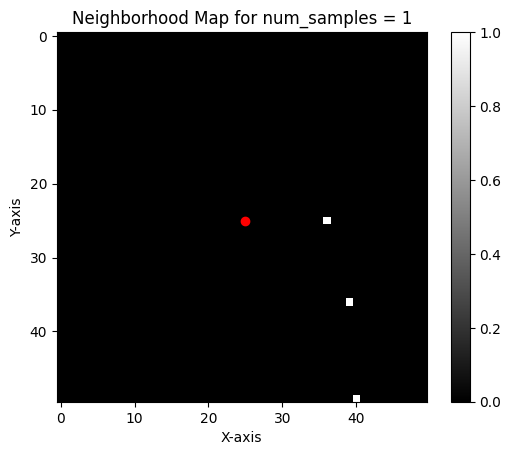

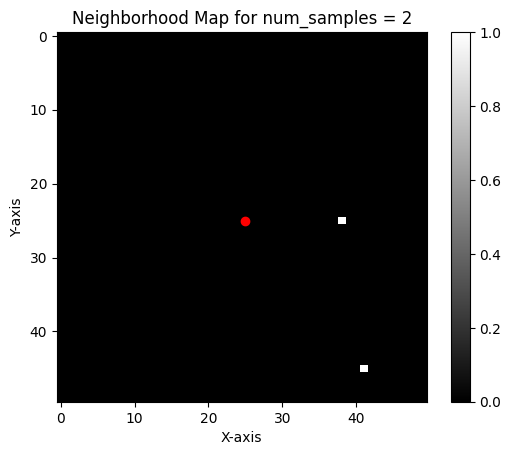

mip_positions shape = (6013, 2, 1)
candidate_positions shape = (6013, 1017, 4)
cand_pos shape = (6013, 1017, 2)
candidate_positions shape = (6013, 1017, 4)
extended_mip_positions shape = (6013, 1017, 2)
candidate_positions shape = (6013, 1017, 4)


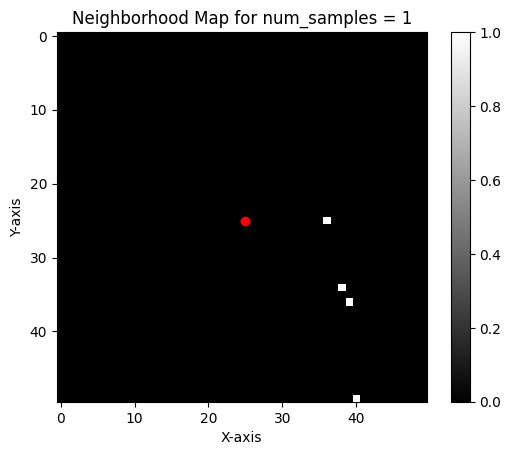

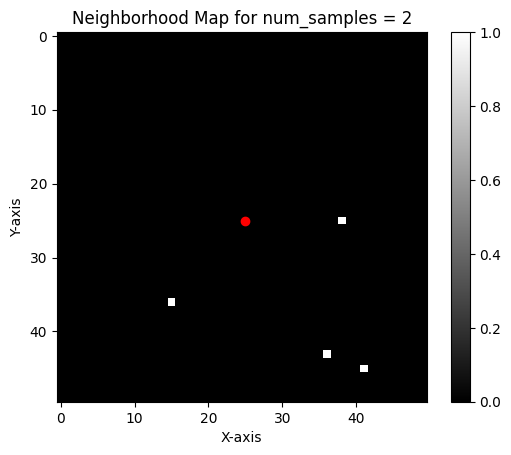

mip_positions shape = (6013, 2, 1)
candidate_positions shape = (6013, 1017, 4)
cand_pos shape = (6013, 1017, 2)
candidate_positions shape = (6013, 1017, 4)
extended_mip_positions shape = (6013, 1017, 2)
candidate_positions shape = (6013, 1017, 4)


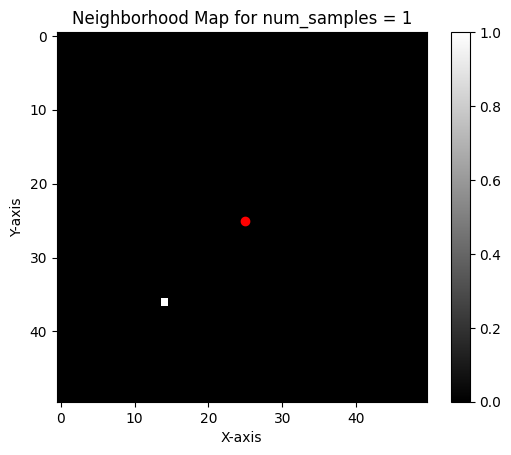

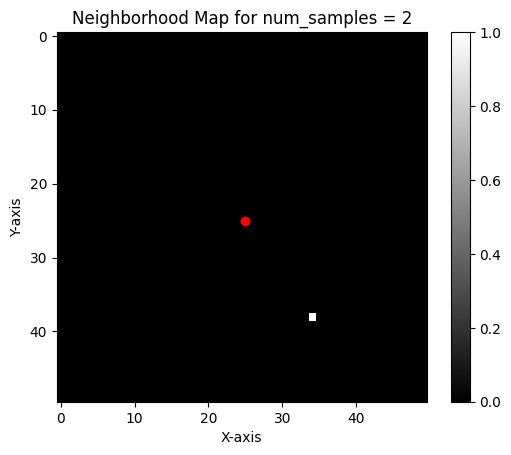

X_map_pion shape: (6013, 50, 50)
X_map_kaon shape: (6013, 50, 50)
X_map_proton shape: (6013, 50, 50)
  return (X_train, X_test, y_train, y_test) 
:


In [22]:

mask = [1,1,1,1]
X_train_scaled, X_test_scaled, X_train, X_test, y_train, y_test = classifier.preprocess_data()


# Plotting histograms of Training Versus Test Sets

In [23]:
!wget https://raw.githubusercontent.com/eflatlan/CNN_PID/models_sacved/misc_helper_functions.py
from misc_helper_functions import *

--2023-09-22 15:44:08--  https://raw.githubusercontent.com/eflatlan/CNN_PID/models_sacved/misc_helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2023-09-22 15:44:08 ERROR 404: Not Found.



In [24]:
# print("===== Evaluating Training Data =====")
# for feature, data in X_train.items():
#     print(f"Evaluating feature: {feature}")
#     eval_data(np.array(data))  # Assuming your function is designed to work with numpy arrays
#     print("---------------------------")

# # Loop through test_data dictionary
# print("===== Evaluating Test Data =====")
# for feature, data in X_test.items():
#     print(f"Evaluating feature: {feature}")
#     eval_data(np.array(data))  # Assuming your function is designed to work with numpy arrays
#     print("---------------------------")

variable shape (4810, 1017, 4)
variable shape (1203, 1017, 4)


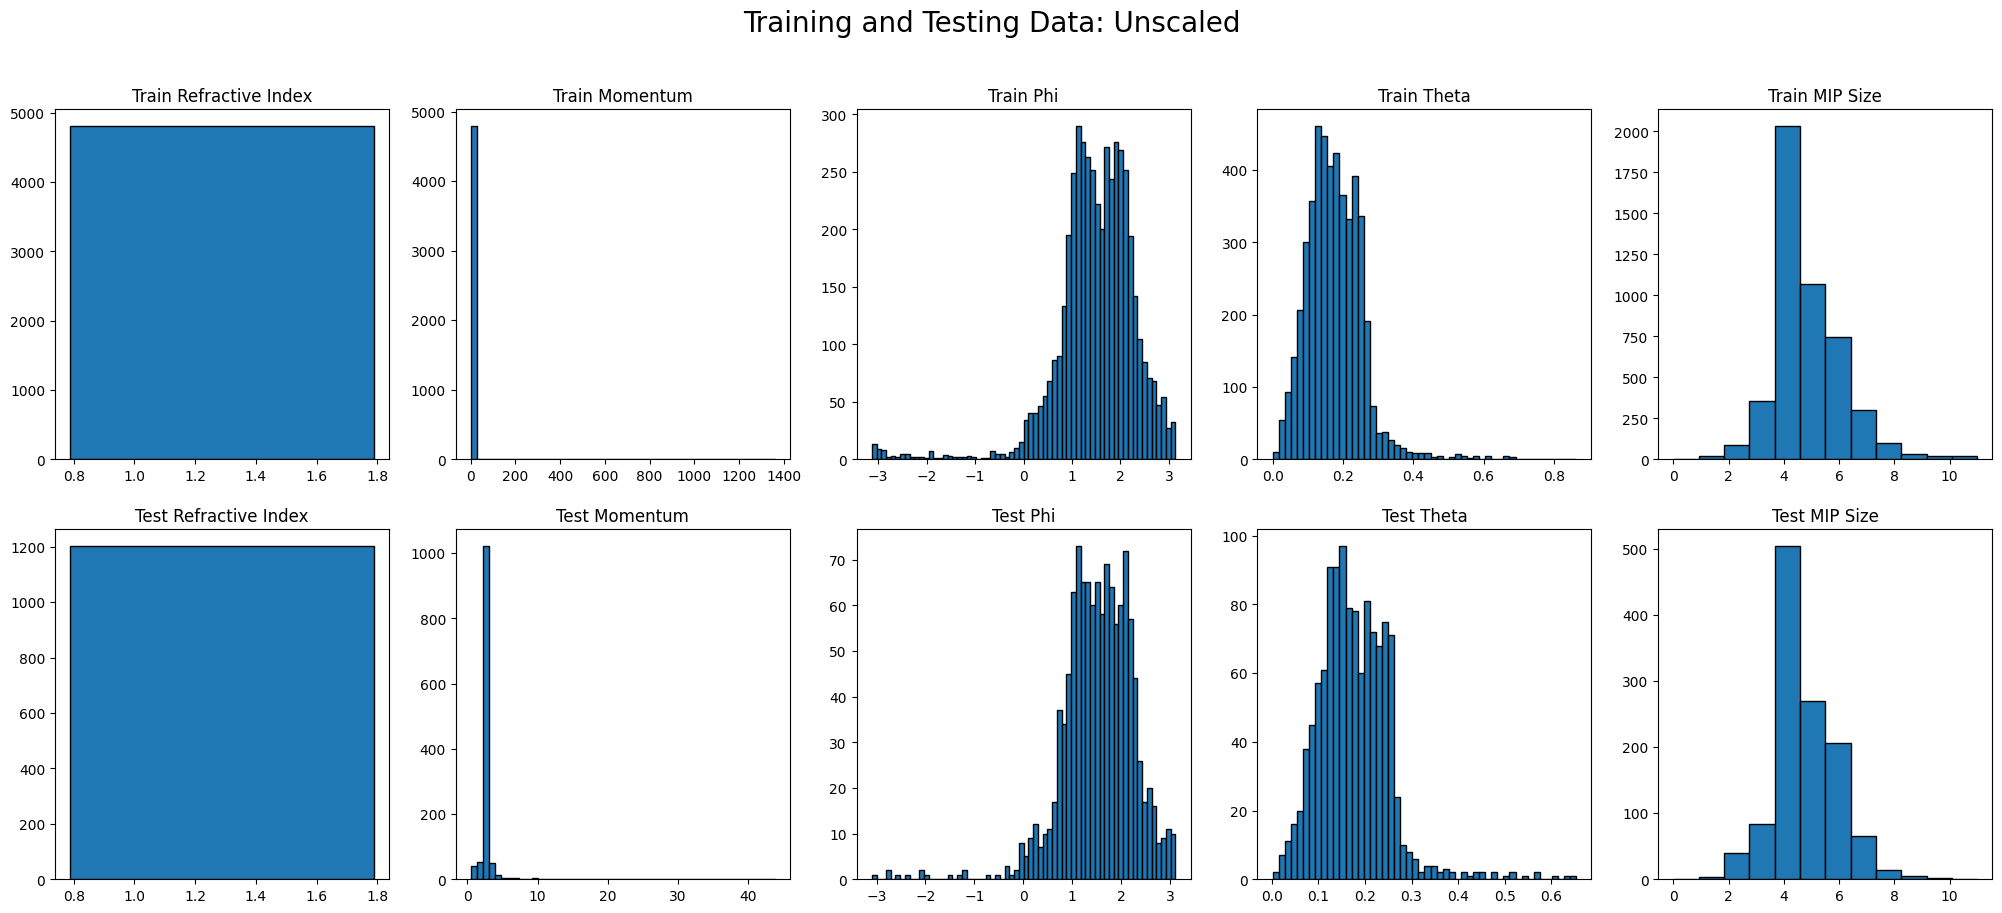

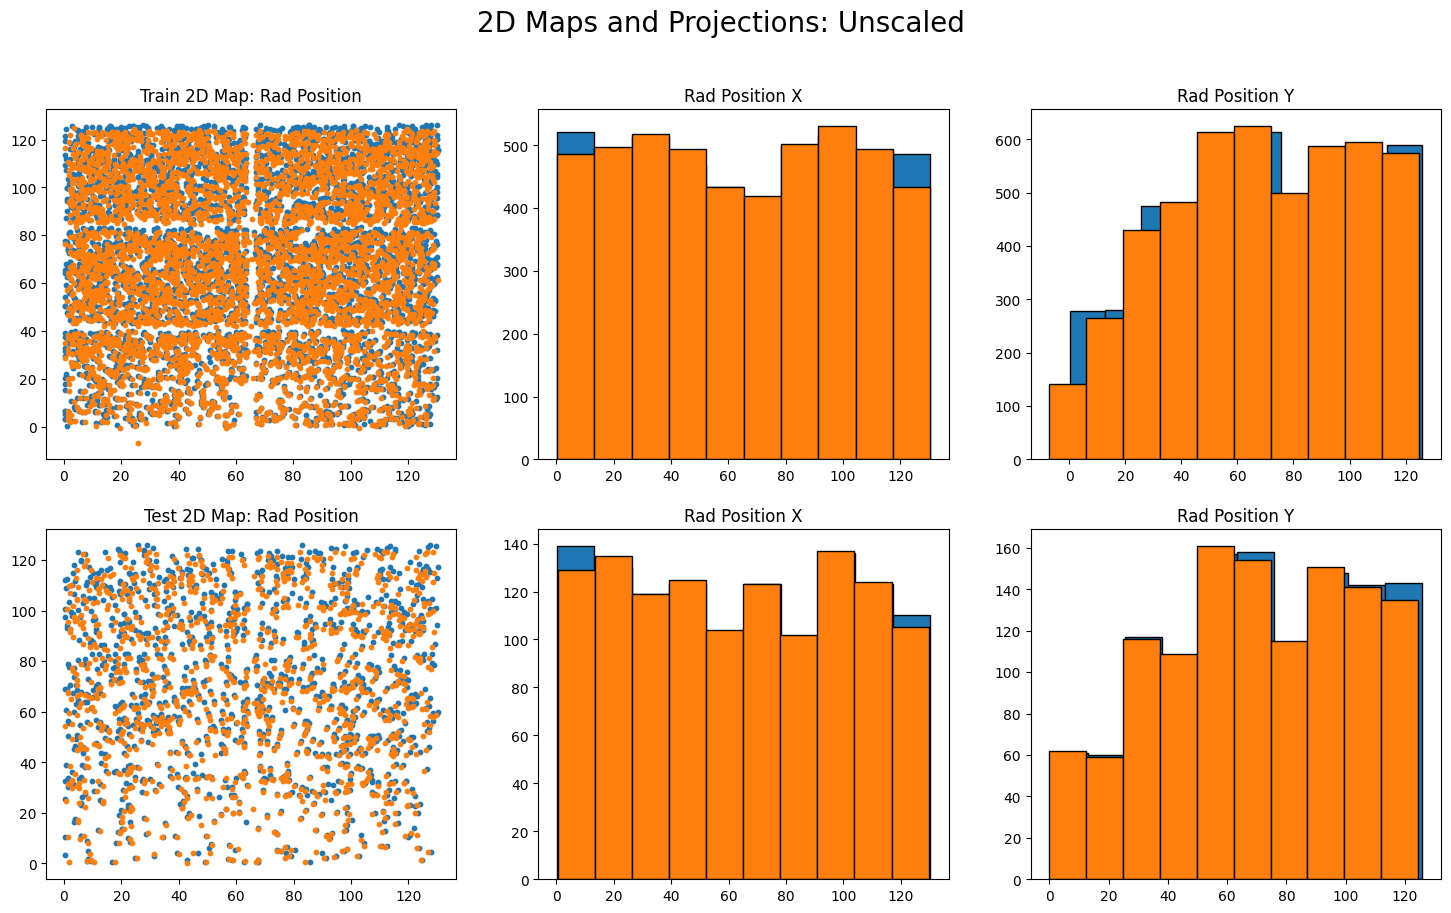

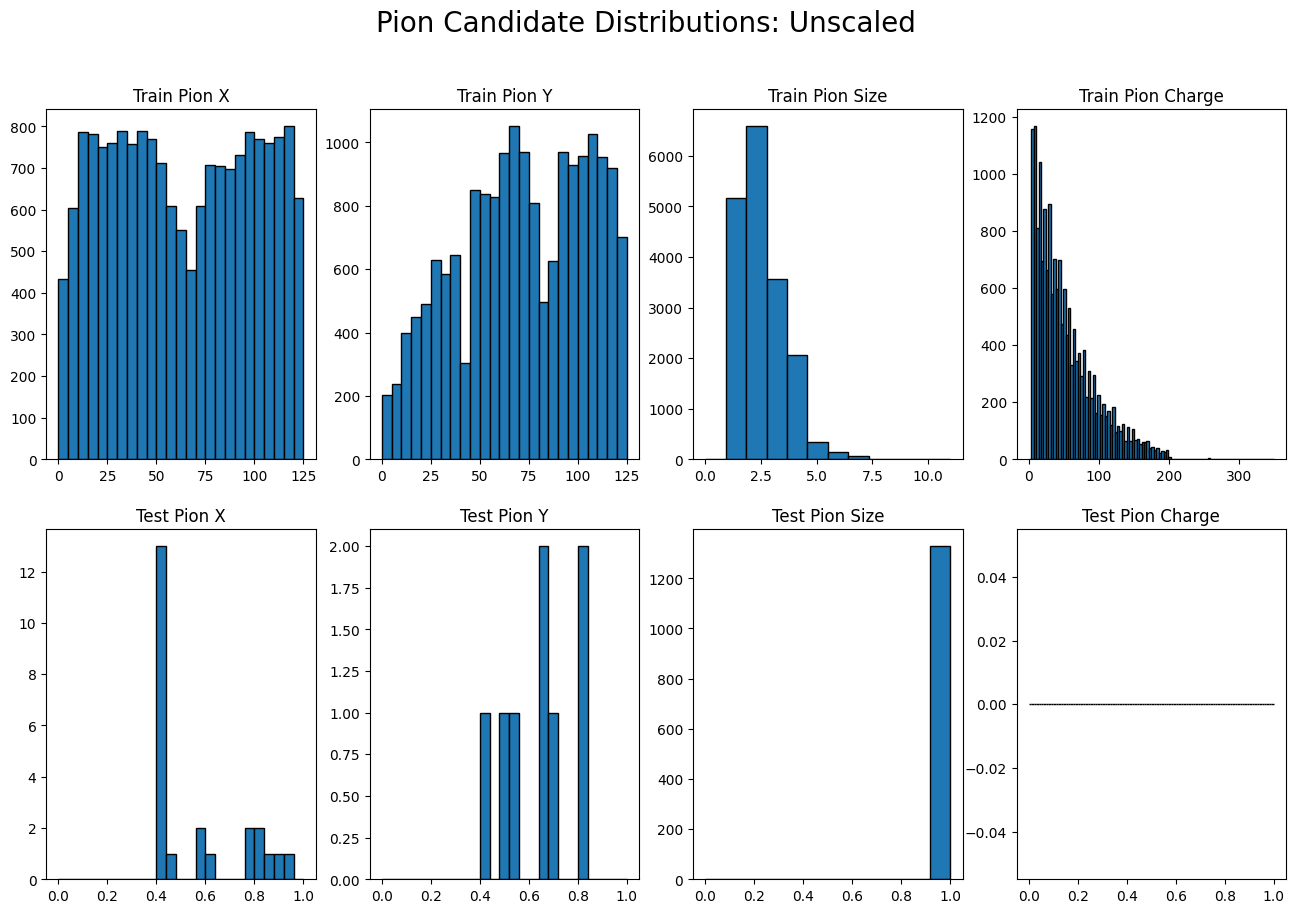

In [25]:
classifier.plot_hist(X_train=X_train, X_test=X_test, description = "Unscaled")


variable shape (4810, 1017, 4)
variable shape (1203, 1017, 4)


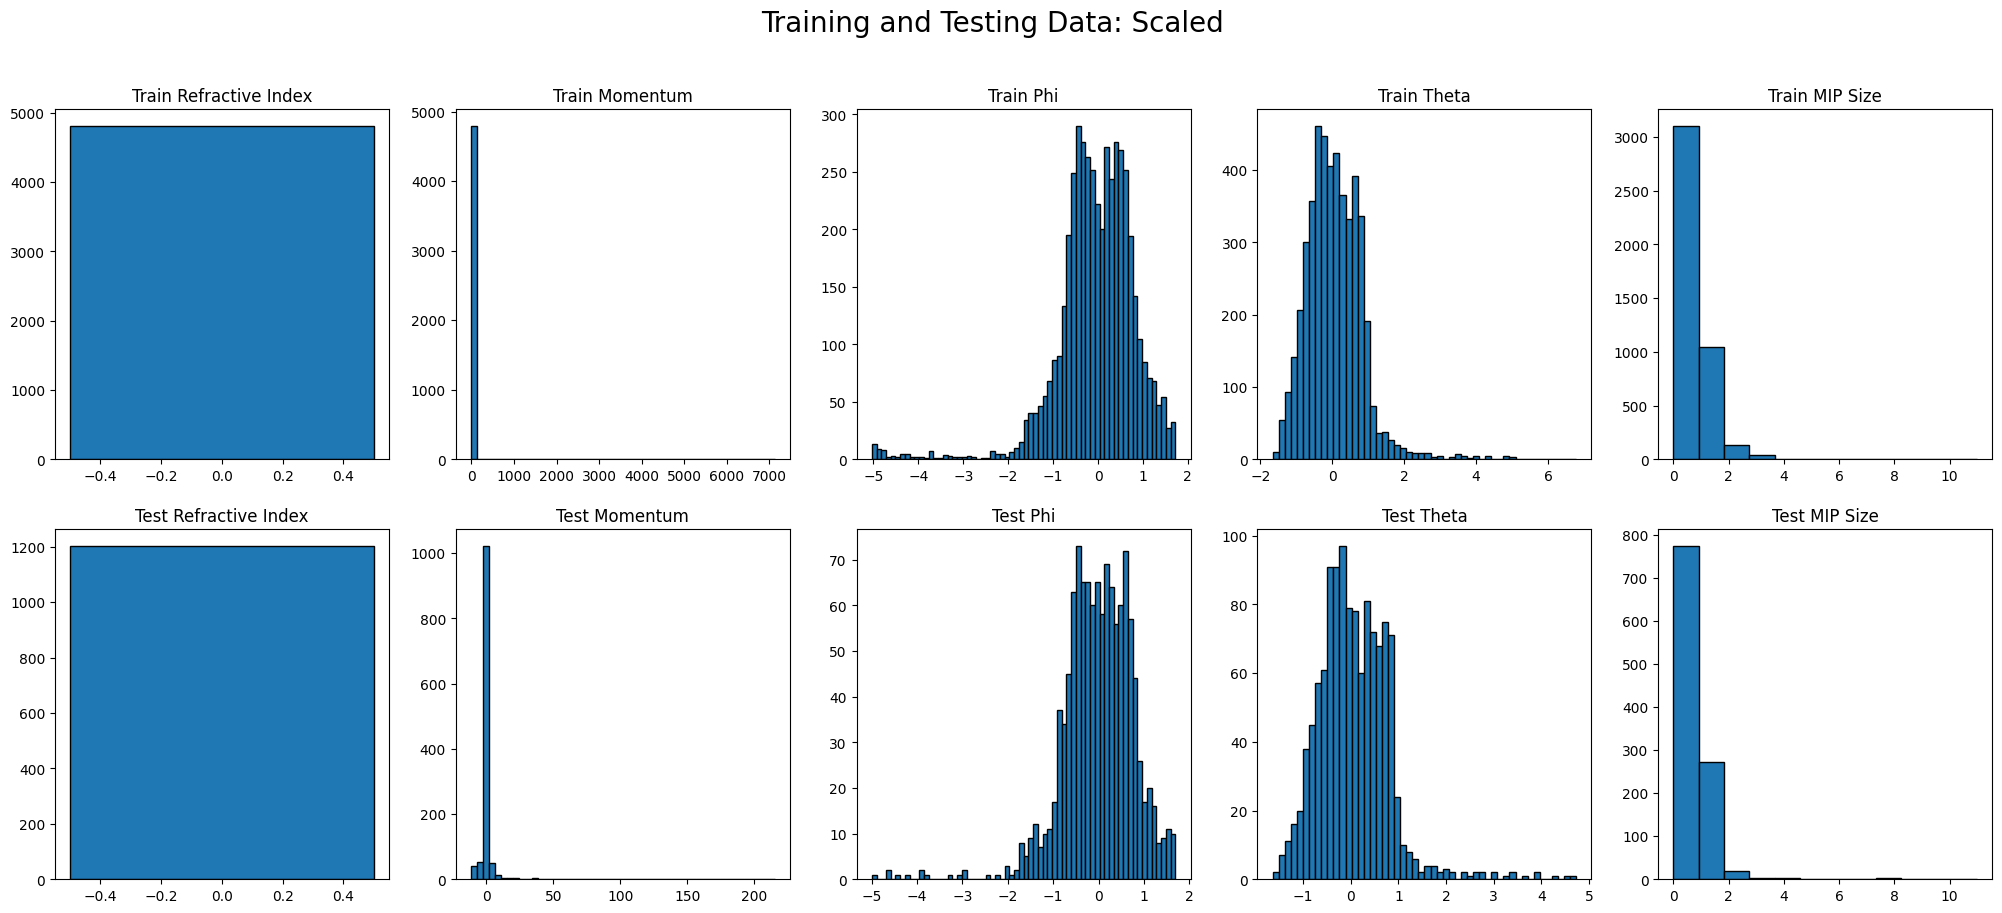

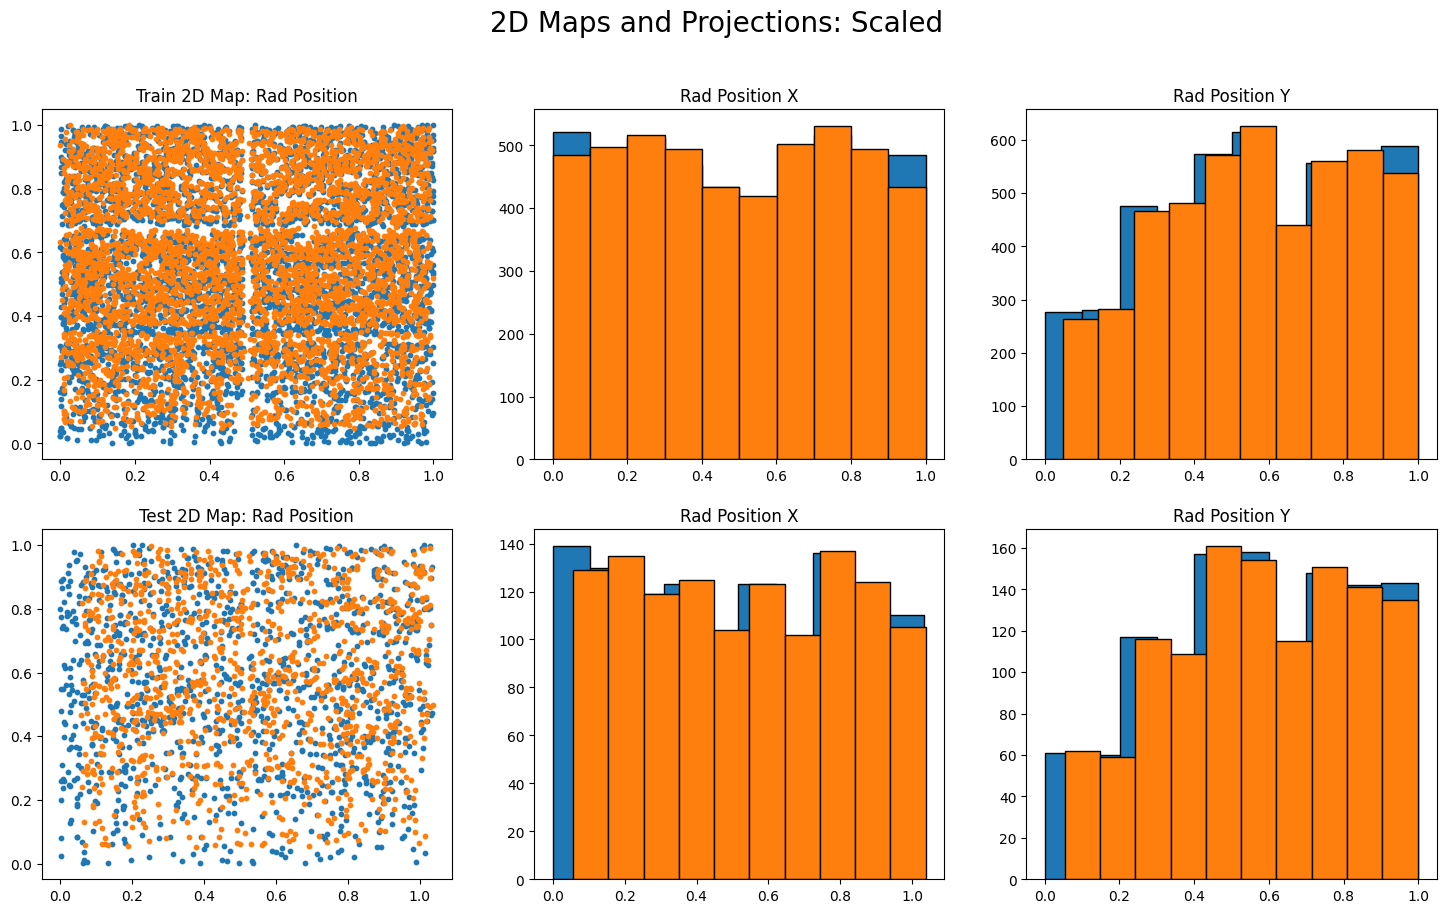

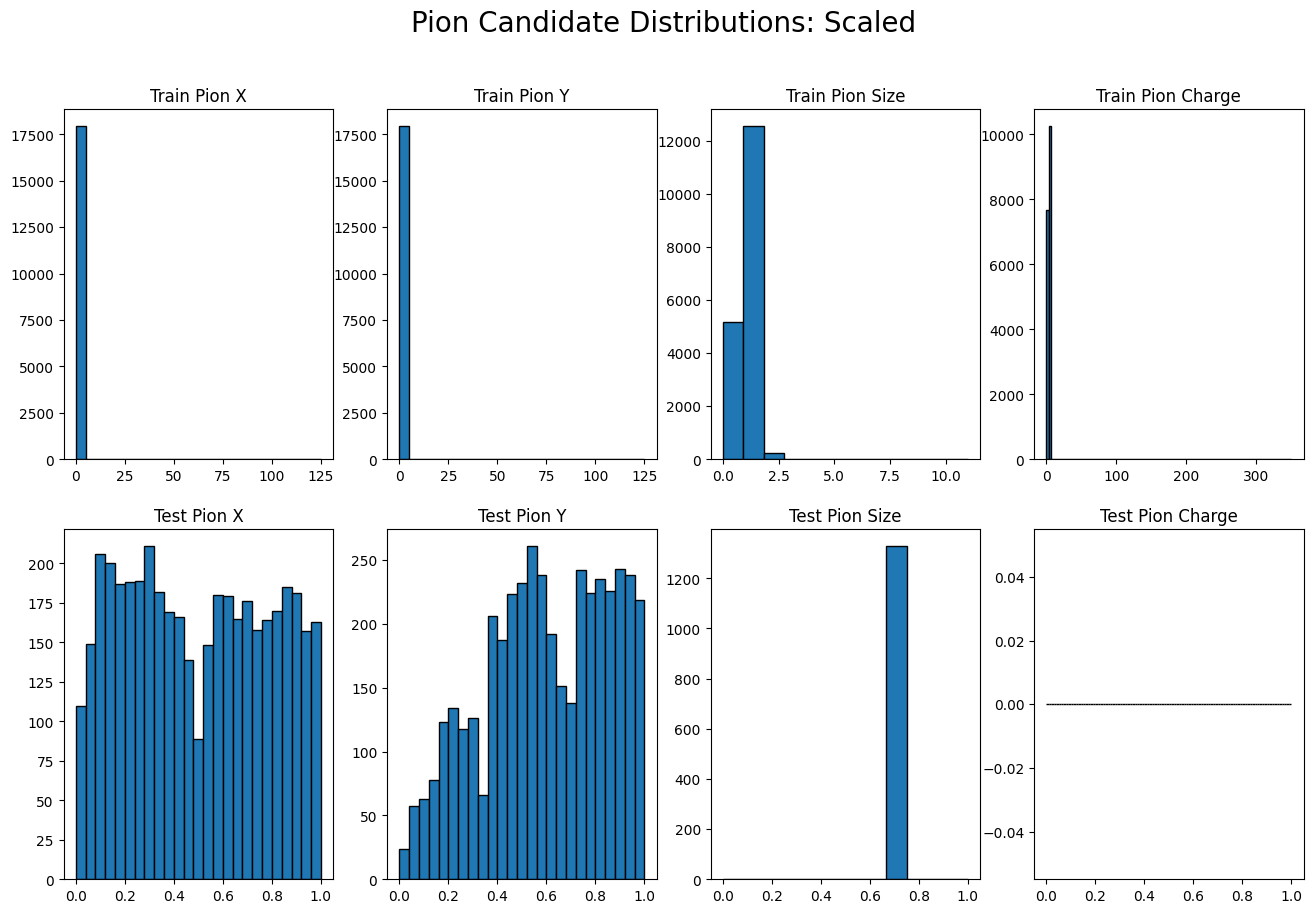

In [26]:
classifier.plot_hist(X_train = X_train_scaled, X_test =  X_test_scaled, description = "Scaled")


# Plot samples

In [27]:

X_train_pion_candidates = X_train["X_train_pion_candidates"]
X_train_kaon_candidates = X_train["X_train_kaon_candidates"]
X_train_proton_candidates = X_train["X_train_proton_candidates"]
X_train_non_candidates = X_train["X_train_non_candidates"]


X_train_momentum = X_train["X_train_momentum"]
X_train_refractive_index = X_train["X_train_refractive_index"]
X_train_phi = X_train["X_train_phi"]
X_train_theta = X_train["X_train_theta"]

X_train_mip_position = X_train["X_train_mip_position"]
X_train_rad_position = X_train["X_train_rad_position"]

X_test_pion_candidates = X_test["X_test_pion_candidates"]
X_test_kaon_candidates = X_test["X_test_kaon_candidates"]
# X_test_proton_candidates = X_test["X_test_proton_candidates"]
X_test_momentum = X_test["X_test_momentum"]
X_test_refractive_index = X_test["X_test_refractive_index"]
X_test_phi = X_test["X_test_phi"]
X_test_theta = X_test["X_test_theta"]
X_test_mip_position = X_test["X_test_mip_position"]
X_test_rad_position = X_test["X_test_rad_position"]

below_zero_indexes = np.where(X_train_phi < 0)[0]
n = 10
first_n_below_zero_indexes = below_zero_indexes[:n]

print(first_n_below_zero_indexes)
#ef : TODO fix this again


[ 80 119 152 186 189 243 257 362 411 425]


# PDG of train vs test

In [28]:
import matplotlib.pyplot as plt
import numpy as np


# for i in range(1,5):
#   print(y_test[i])



# # Counting occurrences in the training set
# train_pion_count = np.sum(y_train[:, 0])
# train_kaon_count = np.sum(y_train[:, 1])
# train_proton_count = np.sum(y_train[:, 2])

# # Counting occurrences in the test set
# test_pion_count = np.sum(y_test[:, 0])
# test_kaon_count = np.sum(y_test[:, 0])
# test_proton_count = np.sum(y_test[:, 2])

# print(f'Train : pion_count {train_pion_count}  kaon_count {train_kaon_count} proton_count {train_proton_count}')
# print(f'Test : pion_count {test_pion_count}  kaon_count {test_kaon_count} proton_count {test_proton_count}')

# # Create subplots
# fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# # Training set histogram
# axs[0].bar(['Pion', 'Kaon', 'Proton'], [train_pion_count, train_kaon_count, train_proton_count])
# axs[0].set_title('Training Set')
# axs[0].set_xlabel('Particle Type')
# axs[0].set_ylabel('Frequency')

# # Test set histogram
# axs[1].bar(['Pion', 'Kaon', 'Proton'], [test_pion_count, test_kaon_count, test_proton_count])
# axs[1].set_title('Test Set')
# axs[1].set_xlabel('Particle Type')
# axs[1].set_ylabel('Frequency')

# plt.show()


In [29]:
#plot_first_instance(1, X_train_pion_candidates, X_train_kaon_candidates, X_train_proton_candidates,\
#                    X_train_non_candidates, X_train_mip_position, X_train_rad_position, X_train_phi, X_train_theta, y_train)



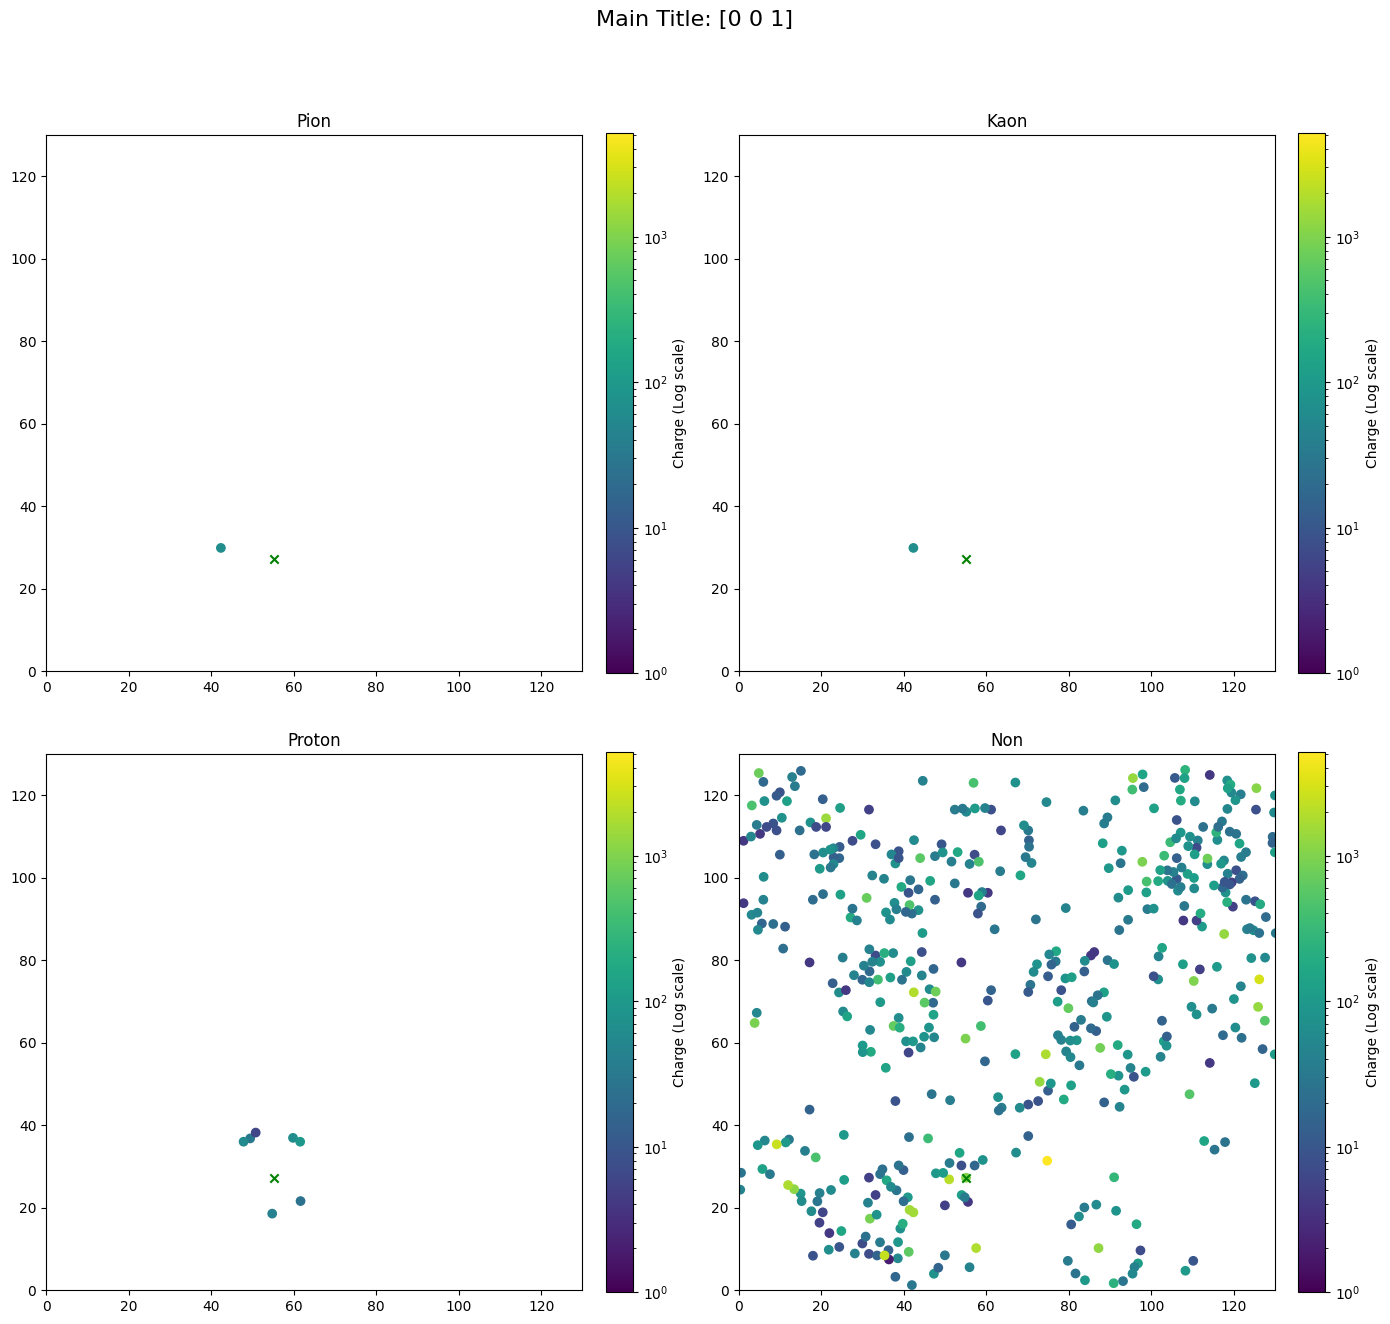

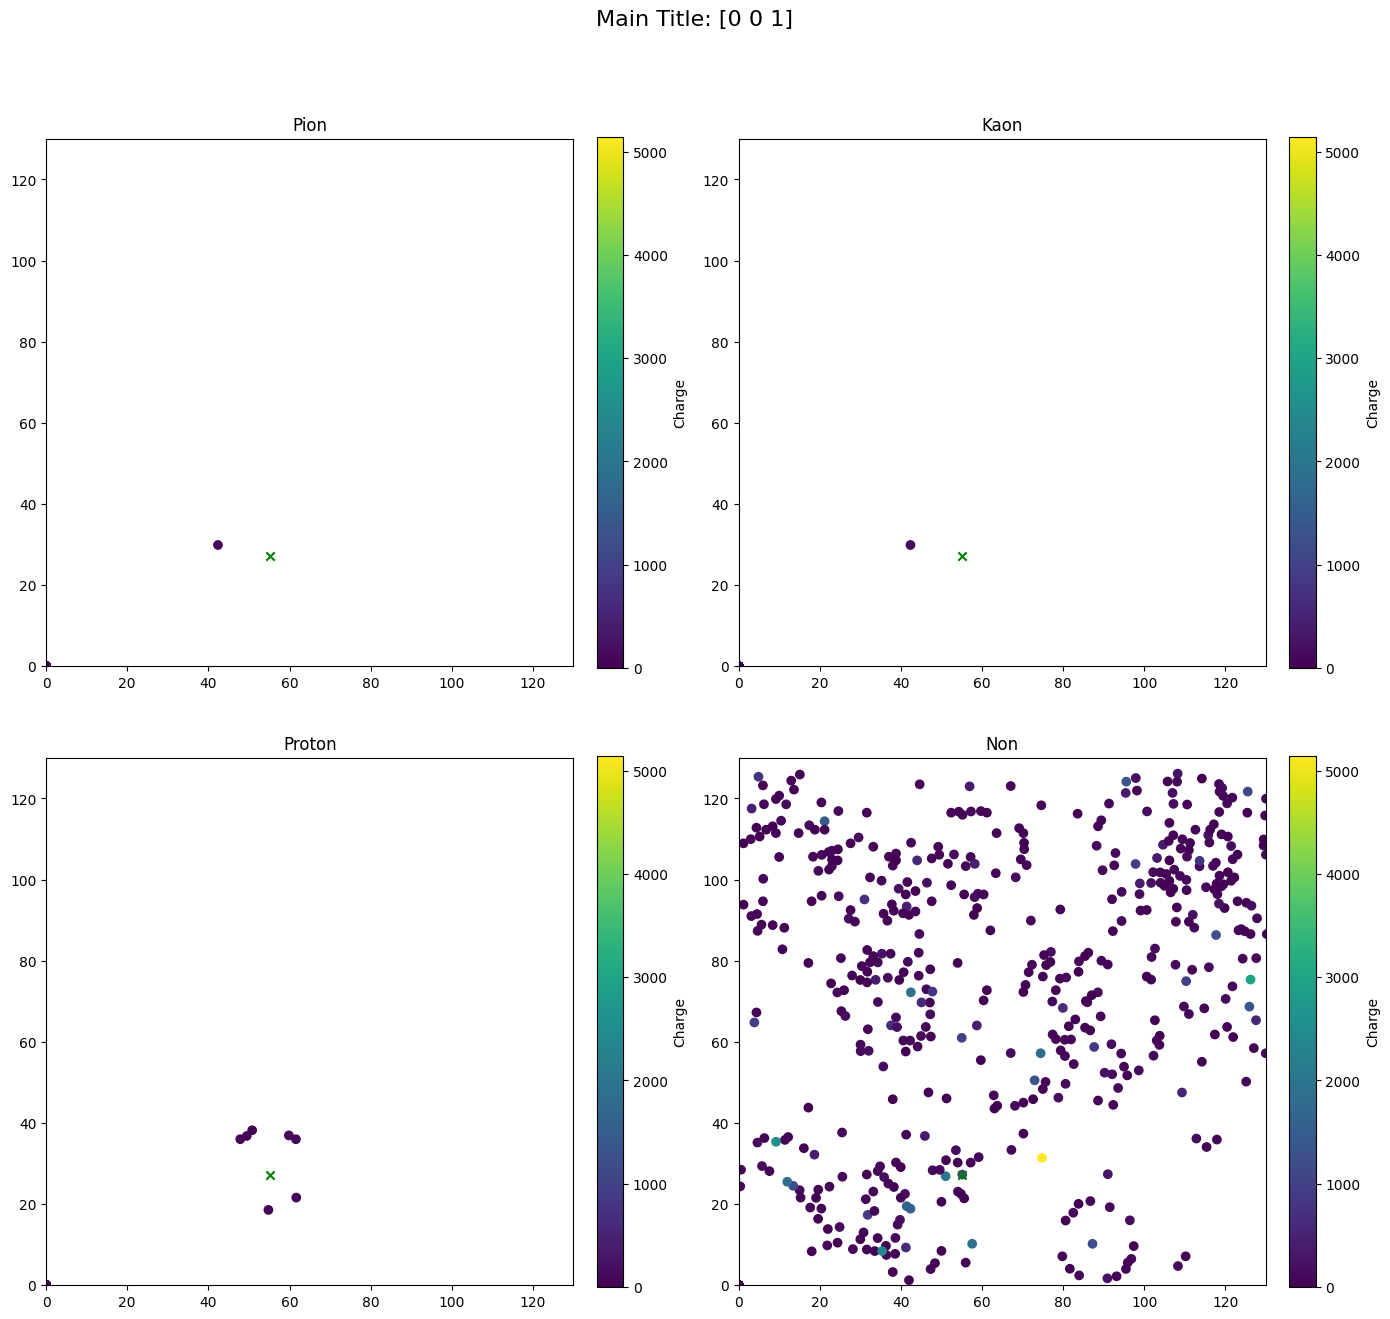

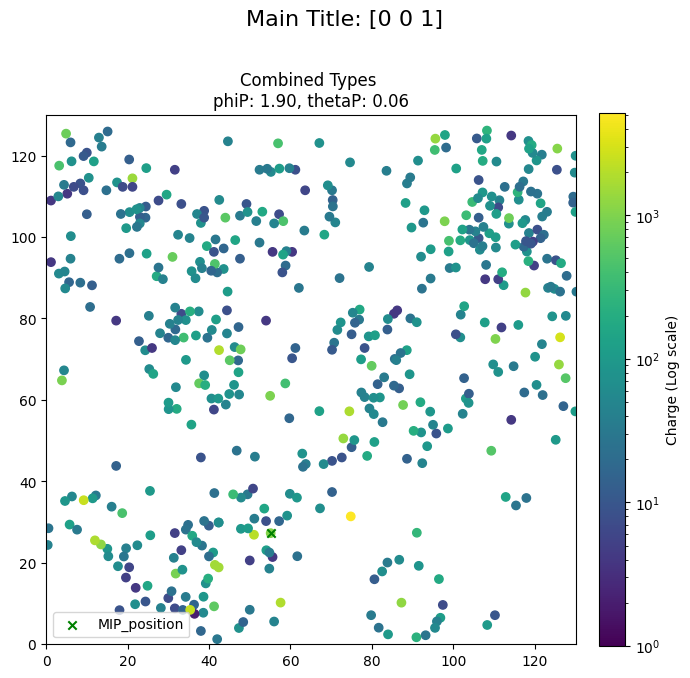

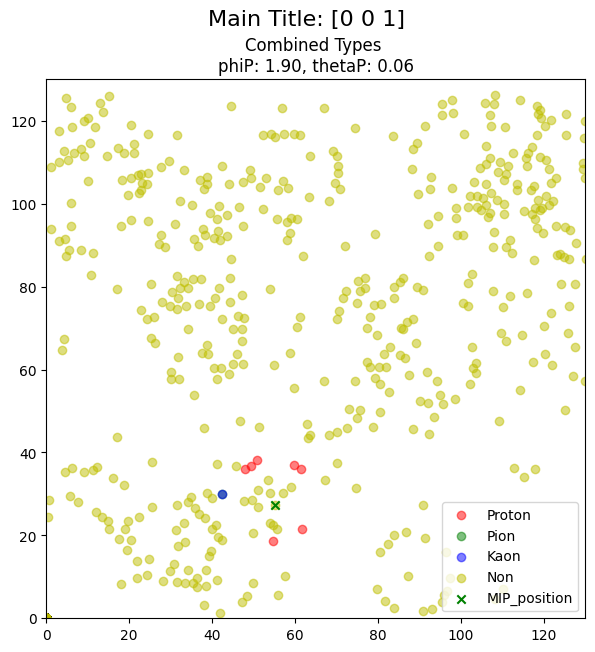

In [30]:
#plot_combined_types(1, X_train_pion_candidates, X_train_kaon_candidates, X_train_proton_candidates, X_train_non_candidates)
#plot_individual_types(5, X_train_pion_candidates, X_train_kaon_candidates, X_train_proton_candidates, X_train_non_candidates)

index = 15
plot_individual_types(index, X_train_pion_candidates, X_train_kaon_candidates, X_train_proton_candidates, X_train_non_candidates,X_train_mip_position, X_train_rad_position, y_train, True)

plot_individual_types(index, X_train_pion_candidates, X_train_kaon_candidates, X_train_proton_candidates, X_train_non_candidates,X_train_mip_position, X_train_rad_position, y_train, False)


plot_combined_types3(index, X_train_pion_candidates, X_train_kaon_candidates, X_train_proton_candidates, X_train_non_candidates,X_train_mip_position, X_train_rad_position, X_train_phi, X_train_theta, y_train)
plot_combined_types(index, X_train_pion_candidates, X_train_kaon_candidates, X_train_proton_candidates, X_train_non_candidates,X_train_mip_position, X_train_rad_position, X_train_phi, X_train_theta, y_train)



In [31]:
#plot_combined_types(22, X_train_pion_candidates, X_train_kaon_candidates, X_train_proton_candidates, X_train_mip_position, X_train_rad_position, X_train_phi, X_train_theta, y_train)

# Training the model


In [ ]:
mask = [1,1,1,1]




fc1_unit = 64
units = [fc1_unit * i for i in [4, 4, 2, 2, 1]]
units2 = [fc1_unit * i for i in [4, 2, 2, 1]]


final_concat_units = [fc1_unit * i for i in [4, 2, 1]]

# units = [fc1_unit * i for i in [8, 4, 2, 2, 1]]
#units2 = [fc1_unit * i for i in [8,  4, 2, 2, 1]]
# units2 = [fc1_unit * i for i in [2, 2, 1]]

CNN_units = None

model = classifier.train(X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test, mask = mask, num_epochs=150, include_cnn = False, units = units, units2 = units2, final_concat_units = final_concat_units, CNN_units = CNN_units)
#classifier.train(X_train = X_train_scaled, X_test = X_test_scaled, y_train = y_train, y_test = y_test, mask = mask, num_epochs=50)


Fields in the first vector of X_train:
X_train_pion_candidates shape: (4810, 1017, 4)
X_train_kaon_candidates shape: (4810, 1017, 4)
X_train_proton_candidates shape: (4810, 1017, 4)
X_train_momentum shape: (4810, 1)
X_train_refractive_index shape: (4810, 1)
X_train_phi shape: (4810, 1)
X_train_theta shape: (4810, 1)
X_train_mip_position shape: (4810, 2, 1)
X_train_rad_position shape: (4810, 2, 1)
X_train_map_pion shape: (4810, 50, 50, 1)
X_train_map_kaon shape: (4810, 50, 50, 1)
X_train_map_proton shape: (4810, 50, 50, 1)

Fields in the first vector of X_test:
X_test_pion_candidates shape: (1203, 1017, 4)
X_test_kaon_candidates shape: (1203, 1017, 4)
X_test_proton_candidates shape: (1203, 1017, 4)
X_test_momentum shape: (1203, 1)
X_test_refractive_index shape: (1203, 1)
X_test_phi shape: (1203, 1)
X_test_theta shape: (1203, 1)
X_test_mip_position shape: (1203, 2, 1)
X_test_rad_position shape: (1203, 2, 1)
X_test_map_pion shape: (1203, 50, 50, 1)
X_test_map_kaon shape: (1203, 50, 50, 1)

In [ ]:
threshold = 0.7

X_test = X_test, y_train = y_train, y_test = y_test
predictions = model.predict(X_test)  # This will give you the softmax output

for pred in predictions:
    max_prob = np.max(pred)
    predicted_class = np.argmax(pred)
    if max_prob > threshold:
        label = class_labels[predicted_class]  # Assuming class_labels is a list of your labels
    else:
        label = 'reject'

In [ ]:
mask = [1,1,1,1]




fc1_unit = 64
units = [fc1_unit * i for i in [64, 32, 16, 16, 8, 4, 4, 2, 2, 1]]
units2 = [fc1_unit * i for i in [64, 32, 16, 16, 8, 4, 4, 2, 2, 1]]

CNN_units = None

classifier.train(X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test, mask = mask, num_epochs=150, include_cnn = True, units = units, units2 = units2, CNN_units = CNN_units)
#classifier.train(X_train = X_train_scaled, X_test = X_test_scaled, y_train = y_train, y_test = y_test, mask = mask, num_epochs=50)

In [ ]:
!wget https://raw.githubusercontent.com/eflatlan/CNN_PID/models_sacved/helper_functions.py
from helper_functions import *

In [ ]:
!wget https://raw.githubusercontent.com/eflatlan/CNN_PID/models_sacved/plot_helper_functions.py
from plot_helper_functions import *

In [ ]:
!wget https://raw.githubusercontent.com/eflatlan/CNN_PID/models_sacved/plot_helper_functions.py
from plot_helper_functions import *